<a href="https://colab.research.google.com/github/devdaveddev/Meta-LoRA/blob/main/MetaLoRa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.4 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM


model_name = "gpt2"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# GPT-2 doesn’t have a pad token by default → set it to EOS
tokenizer.pad_token = tokenizer.eos_token

# Load model (baseline causal LM)
model = AutoModelForCausalLM.from_pretrained(model_name)

print(f"Loaded {model_name} with {model.num_parameters()/1e6:.1f}M parameters")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded gpt2 with 124.4M parameters


In [3]:
from datasets import load_dataset

# Load AG News dataset (open-access)
agnews = load_dataset("ag_news", split="train[:2000]")  # just 2k samples for demo

# Save overlapping text files
!mkdir -p demo_data

# Task 1: Business + World (first 700 samples)
with open("demo_data/task1.txt", "w", encoding="utf-8") as f:
    for row in agnews.select(range(700)):
        f.write(row["text"] + "\n")

# Task 2: World + Sports (samples 500–1200) → overlaps with Task 1 on 200 samples
with open("demo_data/task2.txt", "w", encoding="utf-8") as f:
    for row in agnews.select(range(500, 1200)):
        f.write(row["text"] + "\n")

# Task 3: Sports + Tech (samples 1000–1700) → overlaps with Task 2 on 200 samples
with open("demo_data/task3.txt", "w", encoding="utf-8") as f:
    for row in agnews.select(range(1000, 1700)):
        f.write(row["text"] + "\n")

!ls -lh demo_data

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

total 520K
-rw-r--r-- 1 root root 176K Sep 22 07:25 task1.txt
-rw-r--r-- 1 root root 171K Sep 22 07:25 task2.txt
-rw-r--r-- 1 root root 171K Sep 22 07:25 task3.txt


In [4]:
import os
from datasets import Dataset

# Helper: load a text file into Dataset with tokenization + chunking
def load_txt_dataset(path, tokenizer, block_size=128):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()

    # Tokenize into IDs
    tokens = tokenizer(text, return_tensors="pt")["input_ids"].squeeze().tolist()

    # Split into chunks of length block_size
    chunks = [tokens[i:i+block_size] for i in range(0, len(tokens)-block_size, block_size)]
    return Dataset.from_dict({"input_ids": chunks})

# Task files
task_files = ["demo_data/task1.txt", "demo_data/task2.txt", "demo_data/task3.txt"]

datasets = {}
for i, file in enumerate(task_files, 1):
    if os.path.exists(file):
        datasets[f"task{i}"] = load_txt_dataset(file, tokenizer)
        print(f" Loaded {file}: {len(datasets[f'task{i}'])} samples")
    else:
        print(f" Missing file: {file}")


Token indices sequence length is longer than the specified maximum sequence length for this model (40140 > 1024). Running this sequence through the model will result in indexing errors


 Loaded demo_data/task1.txt: 313 samples
 Loaded demo_data/task2.txt: 308 samples
 Loaded demo_data/task3.txt: 311 samples


In [5]:
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import torch
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

def train_lora_for_task(task_name, dataset, base_model, tokenizer, save_dir="adapters", block_size=128):
    """
    Fine-tunes a LoRA adapter on a given task dataset.
    """
    print(f"\n Training LoRA adapter for {task_name}")

    # Clone base model for task
    model = AutoModelForCausalLM.from_pretrained(base_model).to(device)

    # LoRA config
    lora_cfg = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["c_attn","c_proj"],  # GPT-2 layers
        lora_dropout=0.05,
        task_type=TaskType.CAUSAL_LM
    )
    model = get_peft_model(model, lora_cfg)
    model.print_trainable_parameters()

    # Prepare DataLoader
    def collate_fn(batch):
        # Find the maximum sequence length in the batch
        max_len = max([len(x["input_ids"]) for x in batch])
        # Pad sequences to the maximum length
        padded_batch = []
        for x in batch:
            padding_length = max_len - len(x["input_ids"])
            padded_input_ids = x["input_ids"] + [tokenizer.pad_token_id] * padding_length
            padded_batch.append(padded_input_ids)

        batch = torch.stack([torch.tensor(x) for x in padded_batch])
        return {"input_ids": batch.to(device), "labels": batch.to(device)}

    loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

    # Optimizer
    optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

    # Training loop (short demo)
    model.train()
    for step, batch in enumerate(loader):
        if step > 100:  # limit steps for demo
            break
        optim.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optim.step()
        if step % 10 == 0:
            print(f"Step {step} | Loss: {loss.item():.4f}")

    # Save adapter
    os.makedirs(save_dir, exist_ok=True)
    adapter_path = os.path.join(save_dir, f"{task_name}_lora")
    model.save_pretrained(adapter_path)
    print(f"Saved adapter at {adapter_path}")

    return adapter_path

import os
from datasets import Dataset

# Helper: load a text file into Dataset with tokenization + chunking
def load_txt_dataset(path, tokenizer, block_size=128):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()

    # Tokenize into IDs
    tokens = tokenizer(text, return_tensors="pt")["input_ids"].squeeze().tolist()

    # Split into chunks of length block_size
    chunks = [tokens[i:i+block_size] for i in range(0, len(tokens)-block_size, block_size)]
    return Dataset.from_dict({"input_ids": chunks})

# Task files
task_files = ["demo_data/task1.txt", "demo_data/task2.txt", "demo_data/task3.txt"]

datasets = {}
for i, file in enumerate(task_files, 1):
    if os.path.exists(file):
        datasets[f"task{i}"] = load_txt_dataset(file, tokenizer)
        print(f" Loaded {file}: {len(datasets[f'task{i}'])} samples")
    else:
        print(f" Missing file: {file}")


adapter_dirs = {}
for task_name, dataset in datasets.items():
    adapter_dirs[task_name] = train_lora_for_task(task_name, dataset, model_name, tokenizer)

 Loaded demo_data/task1.txt: 313 samples
 Loaded demo_data/task2.txt: 308 samples
 Loaded demo_data/task3.txt: 311 samples

 Training LoRA adapter for task1


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step 0 | Loss: 5.0244
Step 10 | Loss: 4.1845
Step 20 | Loss: 4.5115
Step 30 | Loss: 4.9447
Step 40 | Loss: 4.9685
Step 50 | Loss: 5.6611
Step 60 | Loss: 5.1134
Step 70 | Loss: 4.1023
Step 80 | Loss: 4.3184
Step 90 | Loss: 4.2548
Step 100 | Loss: 4.6322
Saved adapter at adapters/task1_lora

 Training LoRA adapter for task2
trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475
Step 0 | Loss: 4.1048
Step 10 | Loss: 4.6992
Step 20 | Loss: 4.6070
Step 30 | Loss: 4.7367
Step 40 | Loss: 4.6011
Step 50 | Loss: 3.5887
Step 60 | Loss: 4.4148
Step 70 | Loss: 3.9834
Step 80 | Loss: 3.9754
Step 90 | Loss: 4.2696
Step 100 | Loss: 4.1377
Saved adapter at adapters/task2_lora

 Training LoRA adapter for task3
trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475
Step 0 | Loss: 4.4583
Step 10 | Loss: 3.5282
Step 20 | Loss: 4.1614
Step 30 | Loss: 4.4777
Step 40 | Loss: 3.3928
Step 50 | Loss: 4.6546
Step 60 | Loss: 4.6047
Step 70 | Loss: 3.9710
Step 80 | Loss: 3.6

In [6]:
# === Cell A: Extract LoRA deltas from saved adapters into task_deltas ===
from transformers import AutoModelForCausalLM
from peft import PeftModel
import torch, os

# Defensive checks
assert 'adapter_dirs' in globals(), "adapter_dirs not found. Run training cell that produces adapter_dirs."
assert isinstance(adapter_dirs, dict) and len(adapter_dirs) > 0, "adapter_dirs must be a non-empty dict."

task_deltas = {}   # final structure: task_name -> { param_name: tensor(cpu) }

for task_name, adapter_path in adapter_dirs.items():
    if not os.path.exists(adapter_path):
        print(f"Warning: adapter path {adapter_path} for task {task_name} not found; skipping.")
        continue

    # Load base model + attach adapter (PEFT)
    base = AutoModelForCausalLM.from_pretrained(model_name)   # model_name assumed defined earlier
    peft_model = PeftModel.from_pretrained(base, adapter_path)
    peft_model.eval()

    # Collect LoRA params: best to check for common LoRA suffixes
    delta_dict = {}
    for name, param in peft_model.named_parameters():
        # common PEFT LoRA name patterns include 'lora_A', 'lora_B', 'lora', 'lora.scaling' etc.
        # We keep anything that mentions 'lora' to be safe (but exclude optimizer/buffers).
        if "lora" in name.lower():
            # Store CPU tensor copy (detach) for later SVD analysis
            delta_dict[name] = param.detach().cpu().clone()

    if len(delta_dict) == 0:
        # Some PEFT versions store LoRA under 'peft' or different naming. Try alternate strategy:
        for name, param in peft_model.named_parameters():
            if any(x in name.lower() for x in ["adapter", "bias_adapter", "lora"]):
                delta_dict[name] = param.detach().cpu().clone()

    if len(delta_dict) == 0:
        raise RuntimeError(f"No LoRA-like parameters found in adapter at {adapter_path}. Please print(peft_model.named_parameters()) to inspect names.")

    task_deltas[task_name] = delta_dict
    print(f"Extracted {len(delta_dict)} LoRA params for task '{task_name}' from {adapter_path}")

# Quick sanity
print("Tasks with deltas:", list(task_deltas.keys()))


Extracted 72 LoRA params for task 'task1' from adapters/task1_lora
Extracted 72 LoRA params for task 'task2' from adapters/task2_lora
Extracted 72 LoRA params for task 'task3' from adapters/task3_lora
Tasks with deltas: ['task1', 'task2', 'task3']


In [7]:
# === Inspect param names and create layer grouping by transformer block index ===
import re
from collections import defaultdict

# Collect parameter names from the first task in task_deltas
param_names = list(task_deltas[list(task_deltas.keys())[0]].keys())

print("Sample param names (first 40):")
for n in param_names[:40]:
    print(" ", n)

# Group parameters by regex 'transformer.h.<index>'
layer_groups = defaultdict(list)
other = []
pattern = re.compile(r"(transformer\.h\.\d+)")
for p in param_names:
    m = pattern.search(p)
    if m:
        key = m.group(1)   # e.g., "transformer.h.0"
        layer_groups[key].append(p)
    else:
        other.append(p)

# Add "__other__" group for non-transformer params
if other:
    layer_groups["__other__"] = other

# Convert to normal dict for consistency downstream
layer_groups = dict(layer_groups)

print(f"\nFound {len(layer_groups)} transformer layer groups (plus '__other__' if present).")
print("Example groups:")
for k, v in list(layer_groups.items())[:8]:
    print(f"{k} -> {len(v)} params")


Sample param names (first 40):
  base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight
  base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight
  base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight
  base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight
  base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight
  base_model.model.transformer.h.0.mlp.c_proj.lora_B.default.weight
  base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight
  base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight
  base_model.model.transformer.h.1.attn.c_proj.lora_A.default.weight
  base_model.model.transformer.h.1.attn.c_proj.lora_B.default.weight
  base_model.model.transformer.h.1.mlp.c_proj.lora_A.default.weight
  base_model.model.transformer.h.1.mlp.c_proj.lora_B.default.weight
  base_model.model.transformer.h.2.attn.c_attn.lora_A.default.weight
  base_model.model.transformer.h.2.attn.c_attn.lora_B.default.weight
  base_

In [8]:
# === Cell C: Layer-wise SVD compression and per_layer_out ===
import torch, numpy as np, math
from collections import OrderedDict

# Config knobs (match your prior notebook settings)
ENERGY_THRESH_LIST = [0.90, 0.95, 0.99]
BYTES_F32 = 4
BYTES_F16 = 2
COEFF_COMPRESS_S = 8   # set <=0 to disable coeff compression
PRINT_TOP_LAYERS = 10
USE_FISHER = False     # if you later include fisher weighting

def flatten_layer_deltas(task_deltas, layer_param_list, task_order=None):
    """
    Flatten LoRA deltas for a set of params across tasks into X [L, T] (CPU).
    Each column is one task's flattened concatenation of the listed params.
    """
    task_names = task_order if task_order is not None else list(task_deltas.keys())
    vecs = []
    for t in task_names:
        pieces = []
        for p in layer_param_list:
            if p not in task_deltas[t]:
                raise KeyError(f"Parameter {p} missing for task {t}")
            pieces.append(task_deltas[t][p].flatten().cpu())
        vecs.append(torch.cat(pieces))
    X = torch.stack(vecs, dim=1)  # [L, T] on CPU
    return X, task_names

def svd_keep_k_by_energy(X, energy_thresh):
    # X: [L, T] CPU tensor
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    energy = (S**2).cpu().numpy()
    cum = np.cumsum(energy) / (np.sum(energy) + 1e-12)
    k = int(np.searchsorted(cum, energy_thresh) + 1)
    k = max(1, min(k, U.shape[1]))
    U_k = U[:, :k].contiguous()
    coeffs = (U_k.T @ X).contiguous()   # [k, T]
    residuals = (X - U_k @ coeffs).contiguous()
    return U_k, coeffs, residuals, S.cpu().numpy(), cum

def compress_coeffs(coeffs, s):
    # coeffs: [k, T] CPU tensor
    if s is None or s <= 0 or s >= min(coeffs.shape):
        return None, None, coeffs
    Uc, Sc, Vhc = torch.linalg.svd(coeffs, full_matrices=False)
    Uc_s = Uc[:, :s]
    Sc_s = Sc[:s]
    Vhc_s = Vhc[:s, :]
    shared_coeff_mat = (Uc_s * Sc_s.unsqueeze(0)).cpu()   # [k, s]
    per_task_codes = Vhc_s.cpu()                          # [s, T]
    return shared_coeff_mat, per_task_codes, None

def estimate_bytes(L, k, T, residuals, coeffs_shape, use_fp16=False, shared_coeff_mat=None, per_task_codes=None):
    dtype_bytes = BYTES_F16 if use_fp16 else BYTES_F32
    shared_bytes = L * k * dtype_bytes   # U_k elements
    if shared_coeff_mat is None:
        coeffs_bytes_total = coeffs_shape[0] * coeffs_shape[1] * dtype_bytes
        per_task_coeff_MB = coeffs_bytes_total / T / 1024**2
    else:
        shared_coeff_bytes = int(shared_coeff_mat.numel()) * dtype_bytes
        per_task_codes_bytes = int(per_task_codes.numel()) * dtype_bytes
        coeffs_bytes_total = shared_coeff_bytes + per_task_codes_bytes
        per_task_coeff_MB = per_task_codes_bytes / T / 1024**2
    residuals_bytes_total = int(residuals.numel()) * dtype_bytes
    return {
        "shared_MB": shared_bytes / 1024**2,
        "coeffs_MB_total": coeffs_bytes_total / 1024**2,
        "residuals_MB_total": residuals_bytes_total / 1024**2,
        "per_task_coeff_MB": per_task_coeff_MB
    }

# Run per-layer SVD and fill per_layer_out
per_layer_out = OrderedDict()
total_shared_MB_f32 = total_coeffs_MB_f32 = total_residuals_MB_f32 = total_per_task_coeff_MB_f32 = 0.0

for energy_thresh in ENERGY_THRESH_LIST:
    print(f"\n=== Energy threshold {energy_thresh:.2f} ===")
    per_layer_out.clear()
    total_shared_MB_f32 = total_coeffs_MB_f32 = total_residuals_MB_f32 = total_per_task_coeff_MB_f32 = 0.0

    for layer, plist in sorted(layer_groups.items(), key=lambda x: x[0]):
        plist_sorted = sorted(plist)
        X, task_order = flatten_layer_deltas(task_deltas, plist_sorted)
        L, T = int(X.shape[0]), int(X.shape[1])

        U_k, coeffs, residuals, Svals, cum_energy = svd_keep_k_by_energy(X, energy_thresh)
        k_eff = int(U_k.shape[1])

        shared_coeff_mat, per_task_codes, _ = compress_coeffs(coeffs, COEFF_COMPRESS_S)

        stor_f32 = estimate_bytes(L, k_eff, T, residuals, coeffs.shape, use_fp16=False,
                                  shared_coeff_mat=shared_coeff_mat, per_task_codes=per_task_codes)

        # reconstruction L2/relative
        recon_l2 = float(torch.norm((U_k @ coeffs + residuals) - X).item())
        recon_rel = recon_l2 / (float(torch.norm(X).item()) + 1e-12)

        per_layer_out[layer] = {
            "L": L,
            "k_eff": k_eff,
            "shared_MB_f32": stor_f32["shared_MB"],
            "coeffs_MB_total_f32": stor_f32["coeffs_MB_total"],
            "residuals_MB_total_f32": stor_f32["residuals_MB_total"],
            "per_task_coeff_MB_f32": stor_f32["per_task_coeff_MB"],
            "recon_l2": recon_l2,
            "recon_rel": recon_rel,
            "cum_energy_first10": cum_energy[:min(10, len(cum_energy))].tolist(),
            "tasks": task_order,
            "param_list": plist_sorted,
            "U_k": U_k,
            "coeffs": coeffs,
            "residuals": residuals
        }

        total_shared_MB_f32 += stor_f32["shared_MB"]
        total_coeffs_MB_f32 += stor_f32["coeffs_MB_total"]
        total_residuals_MB_f32 += stor_f32["residuals_MB_total"]
        total_per_task_coeff_MB_f32 += stor_f32["per_task_coeff_MB"]

    # global totals and break-even
    T_global = len(task_deltas)
    lora_per_task_elements = sum(info["L"] for info in per_layer_out.values())
    lora_per_task_MB = lora_per_task_elements * BYTES_F32 / 1024**2
    lora_total_MB_all_tasks = lora_per_task_MB * T_global

    meta_shared_MB = total_shared_MB_f32 + total_residuals_MB_f32   # if you want to count residuals as shared (we keep them stored as totals)
    meta_per_task_effective_MB = total_per_task_coeff_MB_f32
    meta_total_MB_all_tasks = meta_shared_MB + T_global * meta_per_task_effective_MB

    break_even_T = None
    if meta_per_task_effective_MB < lora_per_task_MB:
        break_even_T = math.ceil(meta_shared_MB / (lora_per_task_MB - meta_per_task_effective_MB))

    print(f"Energy {energy_thresh:.2f} -> shared={meta_shared_MB:.4f}MB, meta_per_task_effective={meta_per_task_effective_MB:.6f}MB, break-even T={break_even_T}")

# After loop, choose default energy threshold to keep results for
chosen_energy = 0.95 if 0.95 in ENERGY_THRESH_LIST else ENERGY_THRESH_LIST[0]
print("\n=== Summary (chosen energy) ===")
print("chosen_energy:", chosen_energy)
print("totals:", {
    "lora_per_task_MB": lora_per_task_MB,
    "meta_shared_MB": meta_shared_MB,
    "meta_per_task_effective_MB": meta_per_task_effective_MB,
    "break_even_T": break_even_T
})



=== Energy threshold 0.90 ===
Energy 0.90 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Energy threshold 0.95 ===
Energy 0.95 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Energy threshold 0.99 ===
Energy 0.99 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Summary (chosen energy) ===
chosen_energy: 0.95
totals: {'lora_per_task_MB': 3.09375, 'meta_shared_MB': 18.5625, 'meta_per_task_effective_MB': 0.0001373291015625, 'break_even_T': 7}


In [8]:
# === Cell C: Layer-wise SVD compression and per_layer_out (FIXED) ===
import torch, numpy as np, math
from collections import OrderedDict

# Config knobs - FIXED: Added more aggressive thresholds
ENERGY_THRESH_LIST = [0.50, 0.70, 0.85, 0.90, 0.95, 0.99]  # Added aggressive options
BYTES_F32 = 4
BYTES_F16 = 2
COEFF_COMPRESS_S = 8   # set <=0 to disable coeff compression
PRINT_TOP_LAYERS = 10
USE_FISHER = False     # if you later include fisher weighting

def flatten_layer_deltas(task_deltas, layer_param_list, task_order=None):
    """
    Flatten LoRA deltas for a set of params across tasks into X [L, T] (CPU).
    Each column is one task's flattened concatenation of the listed params.
    """
    task_names = task_order if task_order is not None else list(task_deltas.keys())
    vecs = []
    for t in task_names:
        pieces = []
        for p in layer_param_list:
            if p not in task_deltas[t]:
                raise KeyError(f"Parameter {p} missing for task {t}")
            pieces.append(task_deltas[t][p].flatten().cpu())
        vecs.append(torch.cat(pieces))
    X = torch.stack(vecs, dim=1)  # [L, T] on CPU
    return X, task_names

def svd_keep_k_by_energy(X, energy_thresh):
    # X: [L, T] CPU tensor
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    energy = (S**2).cpu().numpy()
    cum = np.cumsum(energy) / (np.sum(energy) + 1e-12)
    k = int(np.searchsorted(cum, energy_thresh) + 1)
    k = max(1, min(k, U.shape[1]))
    U_k = U[:, :k].contiguous()
    coeffs = (U_k.T @ X).contiguous()   # [k, T]
    residuals = (X - U_k @ coeffs).contiguous()
    return U_k, coeffs, residuals, S.cpu().numpy(), cum

def compress_coeffs(coeffs, s):
    # coeffs: [k, T] CPU tensor
    if s is None or s <= 0 or s >= min(coeffs.shape):
        return None, None, coeffs
    Uc, Sc, Vhc = torch.linalg.svd(coeffs, full_matrices=False)
    Uc_s = Uc[:, :s]
    Sc_s = Sc[:s]
    Vhc_s = Vhc[:s, :]
    shared_coeff_mat = (Uc_s * Sc_s.unsqueeze(0)).cpu()   # [k, s]
    per_task_codes = Vhc_s.cpu()                          # [s, T]
    return shared_coeff_mat, per_task_codes, None

def estimate_bytes(L, k, T, residuals, coeffs_shape, use_fp16=False, shared_coeff_mat=None, per_task_codes=None):
    dtype_bytes = BYTES_F16 if use_fp16 else BYTES_F32
    shared_bytes = L * k * dtype_bytes   # U_k elements
    if shared_coeff_mat is None:
        coeffs_bytes_total = coeffs_shape[0] * coeffs_shape[1] * dtype_bytes
        per_task_coeff_MB = coeffs_bytes_total / T / 1024**2
    else:
        shared_coeff_bytes = int(shared_coeff_mat.numel()) * dtype_bytes
        per_task_codes_bytes = int(per_task_codes.numel()) * dtype_bytes
        coeffs_bytes_total = shared_coeff_bytes + per_task_codes_bytes
        per_task_coeff_MB = per_task_codes_bytes / T / 1024**2
    residuals_bytes_total = int(residuals.numel()) * dtype_bytes
    return {
        "shared_MB": shared_bytes / 1024**2,
        "coeffs_MB_total": coeffs_bytes_total / 1024**2,
        "residuals_MB_total": residuals_bytes_total / 1024**2,
        "per_task_coeff_MB": per_task_coeff_MB
    }

# FIXED: Store results for all energy thresholds instead of overwriting
per_layer_results_by_threshold = {}  # energy_thresh -> per_layer_out

for energy_thresh in ENERGY_THRESH_LIST:
    print(f"\n=== Energy threshold {energy_thresh:.2f} ===")

    # FIXED: Create new dict for this threshold instead of clearing
    current_per_layer_out = OrderedDict()
    total_shared_MB_f32 = total_coeffs_MB_f32 = total_residuals_MB_f32 = total_per_task_coeff_MB_f32 = 0.0

    for layer, plist in sorted(layer_groups.items(), key=lambda x: x[0]):
        plist_sorted = sorted(plist)
        X, task_order = flatten_layer_deltas(task_deltas, plist_sorted)
        L, T = int(X.shape[0]), int(X.shape[1])

        U_k, coeffs, residuals, Svals, cum_energy = svd_keep_k_by_energy(X, energy_thresh)
        k_eff = int(U_k.shape[1])

        shared_coeff_mat, per_task_codes, _ = compress_coeffs(coeffs, COEFF_COMPRESS_S)

        stor_f32 = estimate_bytes(L, k_eff, T, residuals, coeffs.shape, use_fp16=False,
                                  shared_coeff_mat=shared_coeff_mat, per_task_codes=per_task_codes)

        # reconstruction L2/relative
        recon_l2 = float(torch.norm((U_k @ coeffs + residuals) - X).item())
        recon_rel = recon_l2 / (float(torch.norm(X).item()) + 1e-12)

        current_per_layer_out[layer] = {
            "L": L,
            "k_eff": k_eff,
            "shared_MB_f32": stor_f32["shared_MB"],
            "coeffs_MB_total_f32": stor_f32["coeffs_MB_total"],
            "residuals_MB_total_f32": stor_f32["residuals_MB_total"],
            "per_task_coeff_MB_f32": stor_f32["per_task_coeff_MB"],
            "recon_l2": recon_l2,
            "recon_rel": recon_rel,
            "cum_energy_first10": cum_energy[:min(10, len(cum_energy))].tolist(),
            "tasks": task_order,
            "param_list": plist_sorted,
            "U_k": U_k,
            "coeffs": coeffs,
            "residuals": residuals
        }

        total_shared_MB_f32 += stor_f32["shared_MB"]
        total_coeffs_MB_f32 += stor_f32["coeffs_MB_total"]
        total_residuals_MB_f32 += stor_f32["residuals_MB_total"]
        total_per_task_coeff_MB_f32 += stor_f32["per_task_coeff_MB"]

    # Store results for this threshold
    per_layer_results_by_threshold[energy_thresh] = current_per_layer_out

    # global totals and break-even for this threshold
    T_global = len(task_deltas)
    lora_per_task_elements = sum(info["L"] for info in current_per_layer_out.values())
    lora_per_task_MB = lora_per_task_elements * BYTES_F32 / 1024**2
    lora_total_MB_all_tasks = lora_per_task_MB * T_global

    meta_shared_MB = total_shared_MB_f32 + total_residuals_MB_f32
    meta_per_task_effective_MB = total_per_task_coeff_MB_f32
    meta_total_MB_all_tasks = meta_shared_MB + T_global * meta_per_task_effective_MB

    break_even_T = None
    if meta_per_task_effective_MB < lora_per_task_MB:
        break_even_T = math.ceil(meta_shared_MB / (lora_per_task_MB - meta_per_task_effective_MB))

    print(f"Energy {energy_thresh:.2f} -> shared={meta_shared_MB:.4f}MB, meta_per_task_effective={meta_per_task_effective_MB:.6f}MB, break-even T={break_even_T}")

# Choose default energy threshold to use for downstream analysis
chosen_energy = 0.70 if 0.70 in ENERGY_THRESH_LIST else 0.95  # FIXED: Use more aggressive default
per_layer_out = per_layer_results_by_threshold[chosen_energy]

print(f"\n=== Summary (chosen energy {chosen_energy}) ===")
print("chosen_energy:", chosen_energy)

# Recalculate totals for chosen threshold
total_shared_MB_f32 = sum(info["shared_MB_f32"] for info in per_layer_out.values())
total_coeffs_MB_f32 = sum(info["coeffs_MB_total_f32"] for info in per_layer_out.values())
total_residuals_MB_f32 = sum(info["residuals_MB_total_f32"] for info in per_layer_out.values())
total_per_task_coeff_MB_f32 = sum(info["per_task_coeff_MB_f32"] for info in per_layer_out.values())

lora_per_task_elements = sum(info["L"] for info in per_layer_out.values())
lora_per_task_MB = lora_per_task_elements * BYTES_F32 / 1024**2
meta_shared_MB = total_shared_MB_f32 + total_residuals_MB_f32
meta_per_task_effective_MB = total_per_task_coeff_MB_f32

if meta_per_task_effective_MB < lora_per_task_MB:
    break_even_T = math.ceil(meta_shared_MB / (lora_per_task_MB - meta_per_task_effective_MB))
else:
    break_even_T = None

print("totals:", {
    "lora_per_task_MB": lora_per_task_MB,
    "meta_shared_MB": meta_shared_MB,
    "meta_per_task_effective_MB": meta_per_task_effective_MB,
    "break_even_T": break_even_T
})

# Print comparison across all thresholds
print("\n=== Break-even Comparison Across Thresholds ===")
for thresh in sorted(per_layer_results_by_threshold.keys()):
    layer_data = per_layer_results_by_threshold[thresh]

    # Recalculate for this threshold
    tot_shared = sum(info["shared_MB_f32"] for info in layer_data.values())
    tot_residuals = sum(info["residuals_MB_total_f32"] for info in layer_data.values())
    tot_coeffs_per_task = sum(info["per_task_coeff_MB_f32"] for info in layer_data.values())

    lora_elements = sum(info["L"] for info in layer_data.values())
    lora_mb = lora_elements * BYTES_F32 / 1024**2
    shared_mb = tot_shared + tot_residuals

    if tot_coeffs_per_task < lora_mb:
        be = math.ceil(shared_mb / (lora_mb - tot_coeffs_per_task))
    else:
        be = "inf"

    avg_k = np.mean([info["k_eff"] for info in layer_data.values()])
    print(f"Energy {thresh:.2f}: break-even T={be}, avg k={avg_k:.1f}, shared={shared_mb:.2f}MB")


=== Energy threshold 0.50 ===
Energy 0.50 -> shared=15.4688MB, meta_per_task_effective=0.000092MB, break-even T=6

=== Energy threshold 0.70 ===
Energy 0.70 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Energy threshold 0.85 ===
Energy 0.85 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Energy threshold 0.90 ===
Energy 0.90 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Energy threshold 0.95 ===
Energy 0.95 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Energy threshold 0.99 ===
Energy 0.99 -> shared=18.5625MB, meta_per_task_effective=0.000137MB, break-even T=7

=== Summary (chosen energy 0.7) ===
chosen_energy: 0.7
totals: {'lora_per_task_MB': 3.09375, 'meta_shared_MB': 18.5625, 'meta_per_task_effective_MB': 0.0001373291015625, 'break_even_T': 7}

=== Break-even Comparison Across Thresholds ===
Energy 0.50: break-even T=6, avg k=2.0, shared=15.47MB
Energy 0.70: bre

In [9]:
# === Cell C (No Residuals Version): Layer-wise SVD compression and per_layer_out ===
import torch, numpy as np, math
from collections import OrderedDict

# Config knobs - same as residual version
ENERGY_THRESH_LIST = [0.50, 0.70, 0.85, 0.90, 0.95, 0.99]
BYTES_F32 = 4
BYTES_F16 = 2
COEFF_COMPRESS_S = 8
PRINT_TOP_LAYERS = 10
USE_FISHER = False

def flatten_layer_deltas(task_deltas, layer_param_list, task_order=None):
    """Flatten LoRA deltas for a set of params across tasks into X [L, T]."""
    task_names = task_order if task_order is not None else list(task_deltas.keys())
    vecs = []
    for t in task_names:
        pieces = []
        for p in layer_param_list:
            if p not in task_deltas[t]:
                raise KeyError(f"Parameter {p} missing for task {t}")
            pieces.append(task_deltas[t][p].flatten().cpu())
        vecs.append(torch.cat(pieces))
    X = torch.stack(vecs, dim=1)  # [L, T]
    return X, task_names

def svd_keep_k_by_energy(X, energy_thresh):
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    energy = (S**2).cpu().numpy()
    cum = np.cumsum(energy) / (np.sum(energy) + 1e-12)
    k = int(np.searchsorted(cum, energy_thresh) + 1)
    k = max(1, min(k, U.shape[1]))
    U_k = U[:, :k].contiguous()
    coeffs = (U_k.T @ X).contiguous()
    return U_k, coeffs, S.cpu().numpy(), cum

def compress_coeffs(coeffs, s):
    if s is None or s <= 0 or s >= min(coeffs.shape):
        return None, None, coeffs
    Uc, Sc, Vhc = torch.linalg.svd(coeffs, full_matrices=False)
    Uc_s = Uc[:, :s]; Sc_s = Sc[:s]; Vhc_s = Vhc[:s, :]
    shared_coeff_mat = (Uc_s * Sc_s.unsqueeze(0)).cpu()
    per_task_codes = Vhc_s.cpu()
    return shared_coeff_mat, per_task_codes, None

def estimate_bytes(L, k, T, coeffs_shape, use_fp16=False, shared_coeff_mat=None, per_task_codes=None):
    dtype_bytes = BYTES_F16 if use_fp16 else BYTES_F32
    shared_bytes = L * k * dtype_bytes
    if shared_coeff_mat is None:
        coeffs_bytes_total = coeffs_shape[0] * coeffs_shape[1] * dtype_bytes
        per_task_coeff_MB = coeffs_bytes_total / T / 1024**2
    else:
        shared_coeff_bytes = int(shared_coeff_mat.numel()) * dtype_bytes
        per_task_codes_bytes = int(per_task_codes.numel()) * dtype_bytes
        coeffs_bytes_total = shared_coeff_bytes + per_task_codes_bytes
        per_task_coeff_MB = per_task_codes_bytes / T / 1024**2
    return {
        "shared_MB": shared_bytes / 1024**2,
        "coeffs_MB_total": coeffs_bytes_total / 1024**2,
        "per_task_coeff_MB": per_task_coeff_MB
    }

# Results container
per_layer_results_by_threshold_nores = {}

for energy_thresh in ENERGY_THRESH_LIST:
    print(f"\n=== Energy threshold {energy_thresh:.2f} (no residuals) ===")
    current_per_layer_out = OrderedDict()
    total_shared_MB_f32 = total_coeffs_MB_f32 = total_per_task_coeff_MB_f32 = 0.0

    for layer, plist in sorted(layer_groups.items(), key=lambda x: x[0]):
        plist_sorted = sorted(plist)
        X, task_order = flatten_layer_deltas(task_deltas, plist_sorted)
        L, T = int(X.shape[0]), int(X.shape[1])

        U_k, coeffs, Svals, cum_energy = svd_keep_k_by_energy(X, energy_thresh)
        k_eff = int(U_k.shape[1])

        shared_coeff_mat, per_task_codes, _ = compress_coeffs(coeffs, COEFF_COMPRESS_S)
        stor_f32 = estimate_bytes(L, k_eff, T, coeffs.shape,
                                  use_fp16=False,
                                  shared_coeff_mat=shared_coeff_mat,
                                  per_task_codes=per_task_codes)

        # reconstruction WITHOUT residuals
        X_recon = U_k @ coeffs
        recon_l2 = float(torch.norm(X_recon - X).item())
        recon_rel = recon_l2 / (float(torch.norm(X).item()) + 1e-12)

        current_per_layer_out[layer] = {
            "L": L, "k_eff": k_eff,
            "shared_MB_f32": stor_f32["shared_MB"],
            "coeffs_MB_total_f32": stor_f32["coeffs_MB_total"],
            "per_task_coeff_MB_f32": stor_f32["per_task_coeff_MB"],
            "recon_l2": recon_l2, "recon_rel": recon_rel,
            "cum_energy_first10": cum_energy[:min(10, len(cum_energy))].tolist(),
            "tasks": task_order, "param_list": plist_sorted,
            "U_k": U_k, "coeffs": coeffs
        }

        total_shared_MB_f32 += stor_f32["shared_MB"]
        total_coeffs_MB_f32 += stor_f32["coeffs_MB_total"]
        total_per_task_coeff_MB_f32 += stor_f32["per_task_coeff_MB"]

    # Store
    per_layer_results_by_threshold_nores[energy_thresh] = current_per_layer_out

    # global totals
    T_global = len(task_deltas)
    lora_per_task_elements = sum(info["L"] for info in current_per_layer_out.values())
    lora_per_task_MB = lora_per_task_elements * BYTES_F32 / 1024**2
    lora_total_MB_all_tasks = lora_per_task_MB * T_global

    meta_shared_MB = total_shared_MB_f32   # ✅ no residuals
    meta_per_task_effective_MB = total_per_task_coeff_MB_f32
    meta_total_MB_all_tasks = meta_shared_MB + T_global * meta_per_task_effective_MB

    break_even_T = None
    if meta_per_task_effective_MB < lora_per_task_MB:
        break_even_T = math.ceil(meta_shared_MB / (lora_per_task_MB - meta_per_task_effective_MB))

    print(f"Energy {energy_thresh:.2f} -> shared={meta_shared_MB:.4f}MB, meta_per_task_effective={meta_per_task_effective_MB:.6f}MB, break-even T={break_even_T}")

# Pick a threshold
chosen_energy_nores = 0.70 if 0.70 in ENERGY_THRESH_LIST else 0.95
per_layer_out_nores = per_layer_results_by_threshold_nores[chosen_energy_nores]

print(f"\n=== Summary (chosen energy {chosen_energy_nores}, no residuals) ===")



=== Energy threshold 0.50 (no residuals) ===
Energy 0.50 -> shared=6.1875MB, meta_per_task_effective=0.000092MB, break-even T=3

=== Energy threshold 0.70 (no residuals) ===
Energy 0.70 -> shared=9.2812MB, meta_per_task_effective=0.000137MB, break-even T=4

=== Energy threshold 0.85 (no residuals) ===
Energy 0.85 -> shared=9.2812MB, meta_per_task_effective=0.000137MB, break-even T=4

=== Energy threshold 0.90 (no residuals) ===
Energy 0.90 -> shared=9.2812MB, meta_per_task_effective=0.000137MB, break-even T=4

=== Energy threshold 0.95 (no residuals) ===
Energy 0.95 -> shared=9.2812MB, meta_per_task_effective=0.000137MB, break-even T=4

=== Energy threshold 0.99 (no residuals) ===
Energy 0.99 -> shared=9.2812MB, meta_per_task_effective=0.000137MB, break-even T=4

=== Summary (chosen energy 0.7, no residuals) ===


In [9]:
# ====== Memory accounting + table (fixed, single-pass accounting) ======
import math, torch, pandas as pd, numpy as np
from collections import OrderedDict

# Config (adjust if needed)
BYTES_F32 = 4
BYTES_F16 = 2
TASK_POINTS = [1, 10, 50, 100, 500, 1000, 2000]

# Ensure per_layer_out is available and consistent
# per_layer_out[layer] must contain: "L", "k_eff", "per_task_coeff_MB_f32" etc.
# task_deltas must contain one representative task for computing LoRA per-task size.

# 1) Per-layer element counts
per_layer_stats = OrderedDict()
# Use per_layer_out instead of layer_comps
for layer, c in sorted(per_layer_out.items(), key=lambda x: x[0]):
    L = int(c["L"])                # flattened length for that layer
    k = int(c["k_eff"])                # chosen k for that layer
    # Reference T is implicit in how the per_layer_out was computed
    # We can get the number of tasks from the task_deltas variable
    T = len(list(task_deltas.keys()))
    shared_elems = L * k           # elements stored once
    # coeffs_elems = k * T          # total coeff elements across *all* tasks (k x T) - This is incorrect, coeffs are k x T_ref
    coeffs_elems_total = int(c["coeffs_MB_total_f32"] * 1024**2 / BYTES_F32)
    # residuals_elems = L * T       # residuals if stored per-task - This is incorrect, residuals are L x T_ref
    residuals_elems_total = int(c["residuals_MB_total_f32"] * 1024**2 / BYTES_F32)

    per_layer_stats[layer] = {
        "L": L, "k": k, "T_ref": T, # T_ref is the actual number of tasks used
        "shared_elems": shared_elems,
        "coeffs_elems_total": coeffs_elems_total,
        "residuals_elems_total": residuals_elems_total
    }


# 2) Aggregate elemental totals (elements, not bytes) across layers
total_shared_elems = sum(v["shared_elems"] for v in per_layer_stats.values())
total_coeffs_elems = sum(v["coeffs_elems_total"] for v in per_layer_stats.values())
total_residuals_elems = sum(v["residuals_elems_total"] for v in per_layer_stats.values())


# 3) LoRA per-task baseline: compute flatten element count for one task
one_task_key = list(task_deltas.keys())[0]
one_task_elems = sum(task_deltas[one_task_key][p].numel() for p in task_deltas[one_task_key].keys())

# Convert element counts -> MB / GB (float32)
def elems_to_MB(elems, bytes_per_param=BYTES_F32):
    return elems * bytes_per_param / 1024**2
def elems_to_GB(elems, bytes_per_param=BYTES_F32):
    return elems * bytes_per_param / 1024**3

lora_per_task_MB = elems_to_MB(one_task_elems)
lora_per_task_GB = elems_to_GB(one_task_elems)

# Convert meta totals (shared, coeffs, residuals) to MB/GB
meta_shared_MB = elems_to_MB(total_shared_elems)
meta_coeffs_total_MB = elems_to_MB(total_coeffs_elems)
meta_residuals_total_MB = elems_to_MB(total_residuals_elems)

meta_shared_GB = elems_to_GB(total_shared_elems)
meta_coeffs_total_GB = elems_to_GB(total_coeffs_elems)
meta_residuals_total_GB = elems_to_GB(total_residuals_elems)


# Sanity prints (per-layer first few)
print("Per-layer sample (first 12):")
rows = []
for i,(layer, s) in enumerate(per_layer_stats.items()):
    if i>=12: break
    rows.append([layer, s["L"], s["k"], s["shared_elems"], s["coeffs_elems_total"], s["residuals_elems_total"],
                 round(elems_to_MB(s["shared_elems"]),6), round(elems_to_MB(s["coeffs_elems_total"]),8),
                 round(elems_to_MB(s["residuals_elems_total"]),6)])
print(pd.DataFrame(rows, columns=["layer","L","k","shared_elems","coeffs_elems_total","residuals_elems_total",
                                  "shared_MB","coeffs_MB_total","residuals_MB_total"]).to_string(index=False))

print("\n--- Aggregated element totals ---")
print(f"total_shared_elems = {total_shared_elems}")
print(f"total_coeffs_elems = {total_coeffs_elems}")
print(f"total_residuals_elems = {total_residuals_elems}")
print()
print(f"LoRA per-task: {one_task_elems} elems -> {lora_per_task_MB:.6f} MB -> {lora_per_task_GB:.6f} GB")

print(f"Meta shared basis total: {total_shared_elems} elems -> {meta_shared_MB:.6f} MB -> {meta_shared_GB:.6f} GB")
print(f"Meta coeffs total (all tasks): {total_coeffs_elems} elems -> {meta_coeffs_total_MB:.6f} MB -> {meta_coeffs_total_GB:.6f} GB")
print(f"Meta residuals total (all tasks): {total_residuals_elems} elems -> {meta_residuals_total_MB:.6f} MB -> {meta_residuals_total_GB:.6f} GB")


# 4) For a range of T, compute full tables (three scenarios)
table_rows = []
# Get T_ref from the computed per_layer_stats
T_ref = list(per_layer_stats.values())[0]["T_ref"]
for Tq in TASK_POINTS:
    # A) Vanilla LoRA: per-task * T
    lora_total_GB = lora_per_task_GB * Tq

    # B1) Meta exact storage (store residuals per task + coeffs per task + shared once)
    # meta_total_exact = shared + coeffs_total + residuals_total scaled to Tq
    # Since coeffs_total and residuals_total were computed for T_ref tasks, scale them to Tq proportionally
    scale = Tq / float(T_ref)
    meta_shared_const_GB = meta_shared_GB
    meta_coeffs_total_scaled_GB = meta_coeffs_total_GB * scale
    meta_residuals_total_scaled_GB = meta_residuals_total_GB * scale
    meta_total_exact_GB = meta_shared_const_GB + meta_coeffs_total_scaled_GB + meta_residuals_total_scaled_GB


    # B2) Meta drop residuals (store only shared once + coeffs per task scaled with Tq)
    # Calculate per-task coeffs and residuals based on the scaled total values
    meta_coeffs_per_task_GB = meta_coeffs_total_scaled_GB / Tq if Tq > 0 else 0 # per-task coeffs in GB (using Tq)
    meta_slope_GB = meta_coeffs_per_task_GB  # slope per additional task when drop residuals
    meta_total_drop_GB = meta_shared_const_GB + meta_slope_GB * Tq

    table_rows.append({
        "Tasks (T)": Tq,
        "LoRA total (GB)": round(lora_total_GB, 6),
        "Meta total exact (GB)": round(meta_total_exact_GB, 6),
        "Meta total drop_residuals (GB)": round(meta_total_drop_GB, 6),
        "Meta constant shared (GB)": round(meta_shared_const_GB, 6),
        "Meta slope_per_task (GB)": round(meta_slope_GB, 9)
    })

df_table = pd.DataFrame(table_rows)

# 5) break-even T for drop_residuals model: solve meta_shared + slope*T < LoRA_per_task*T
# => T > meta_shared / (lora_per_task_GB - slope)
# Get the slope from the dataframe for Tq=1
slope = df_table[df_table["Tasks (T)"] == 1]["Meta slope_per_task (GB)"].iloc[0]
if lora_per_task_GB > slope:
    break_even_T = math.ceil(meta_shared_GB / (lora_per_task_GB - slope))
else:
    break_even_T = None

print("\n=== Storage table (GB) ===")
print(df_table.to_string(index=False))
print("\nBreak-even T (drop residuals) =", break_even_T)

# 6) Extra sanity: verify meta_total_exact at T_ref equals shared + coeffs_total + residuals_total
T_ref = list(per_layer_stats.values())[0]["T_ref"]
meta_total_exact_Tref_GB = meta_shared_GB + meta_coeffs_total_GB + meta_residuals_total_GB
print("\nSanity check (T_ref totals):")
print("meta_total_exact_Tref_GB:", round(meta_total_exact_Tref_GB, 9))

Per-layer sample (first 12):
           layer     L  k  shared_elems  coeffs_elems_total  residuals_elems_total  shared_MB  coeffs_MB_total  residuals_MB_total
 transformer.h.0 67584  3        202752                   9                 202752   0.773438         0.000034            0.773438
 transformer.h.1 67584  3        202752                   9                 202752   0.773438         0.000034            0.773438
transformer.h.10 67584  3        202752                   9                 202752   0.773438         0.000034            0.773438
transformer.h.11 67584  3        202752                   9                 202752   0.773438         0.000034            0.773438
 transformer.h.2 67584  3        202752                   9                 202752   0.773438         0.000034            0.773438
 transformer.h.3 67584  3        202752                   9                 202752   0.773438         0.000034            0.773438
 transformer.h.4 67584  3        202752               

In [12]:
# === Reconstruct adapters from layer-wise SVD and evaluate reconstruction + optional PPL ===
import torch, math, numpy as np
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, PeftModel
from torch.utils.data import DataLoader
import torch.nn.functional as F

# ---------- Config ----------
ENERGY_THRESH = 0.95     # choose the energy threshold you tested
COEFF_COMPRESS_S = 8     # must match what used in analysis (0 = no coeff compression)
DO_EVAL_PPL = True       # set False to skip PPL eval
EVAL_SAMPLES = 200       # number of validation tokens/chunks to evaluate (small)
EVAL_BATCH = 4
BASE_MODEL = model_name  # from your notebook, e.g. "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ----------------------------

# helper: recompute per-layer SVD (so we have U_k, coeffs, residuals accessible)
def compute_layer_svds(task_deltas, layer_groups, energy_thresh=0.95, use_fisher=False, fisher_weights=None):
    per_layer_components = {}  # layer -> dict(U_k, coeffs, residuals, param_list, L)
    for layer, plist in sorted(layer_groups.items(), key=lambda x: x[0]):
        plist_sorted = sorted(plist)
        # flatten X [L, T]
        vecs = []
        tasks = list(task_deltas.keys())
        for t in tasks:
            pieces = []
            for p in plist_sorted:
                arr = task_deltas[t][p].flatten().cpu()
                if use_fisher and fisher_weights is not None:
                    arr = arr * fisher_weights[t]
                pieces.append(arr)
            vecs.append(torch.cat(pieces))
        X = torch.stack(vecs, dim=1)  # [L, T]
        # SVD
        U, S, Vh = torch.linalg.svd(X, full_matrices=False)
        energy = (S**2).cpu().numpy()
        cum = np.cumsum(energy) / (np.sum(energy) + 1e-12)
        k = int(np.searchsorted(cum, energy_thresh) + 1)
        k = max(1, min(k, U.shape[1]))
        U_k = U[:, :k]                 # [L, k]
        coeffs = U_k.T @ X             # [k, T]
        residuals = X - U_k @ coeffs   # [L, T]
        per_layer_components[layer] = {
            "U_k": U_k, "coeffs": coeffs, "residuals": residuals,
            "param_list": plist_sorted, "L": X.shape[0], "tasks": tasks, "k": k
        }
    return per_layer_components

# Build transformer layer groups (regex as we did earlier)
import re
from collections import defaultdict
def build_layer_groups_by_transformer(param_names):
    groups = defaultdict(list)
    pattern = re.compile(r"(transformer\.h\.\d+)")
    for p in param_names:
        m = pattern.search(p)
        if m:
            key = m.group(1)
            groups[key].append(p)
        else:
            groups["__other__"].append(p)
    return dict(groups)

param_names = list(task_deltas[list(task_deltas.keys())[0]].keys())
layer_groups = build_layer_groups_by_transformer(param_names)

# Recompute per-layer components
layer_comps = compute_layer_svds(task_deltas, layer_groups, energy_thresh=ENERGY_THRESH,
                                 use_fisher=False, fisher_weights=None)
print("Computed per-layer components for", len(layer_comps), "layers.")

# Optionally compress coeffs per-layer to s components for storage estimate and reconstruction
def compress_coeffs_s(coeffs, s):
    if s <= 0 or s >= min(coeffs.shape):
        return None, None, coeffs
    Uc, Sc, Vhc = torch.linalg.svd(coeffs.cpu(), full_matrices=False)
    Uc_s = Uc[:, :s]
    Sc_s = Sc[:s]
    Vhc_s = Vhc[:s, :]
    shared_coeff_mat = (Uc_s * Sc_s.unsqueeze(0)).cpu()  # [k, s]
    per_task_codes = Vhc_s.cpu()                         # [s, T]
    # reconstruct approx coeffs if needed: (shared_coeff_mat @ per_task_codes)
    return shared_coeff_mat, per_task_codes, (shared_coeff_mat @ per_task_codes)

# Reconstruct flattened deltas per task from per-layer comps
def reconstruct_task_deltas(layer_comps, compress_s=COEFF_COMPRESS_S):
    task_names = list(next(iter(layer_comps.values()))["tasks"])
    recon_per_task = {t: {} for t in task_names}  # task -> {param_name: tensor}
    recon_stats = {t: {"l2": 0.0, "orig_norm": 0.0} for t in task_names}

    # For each layer, reconstruct X_recon (L, T)
    for layer, c in layer_comps.items():
        U_k = c["U_k"]          # [L, k]
        coeffs = c["coeffs"]    # [k, T]
        residuals = c["residuals"]  # [L, T]
        if compress_s and compress_s > 0:
            _, _, coeffs_approx = compress_coeffs_s(coeffs, compress_s)
            if coeffs_approx is not None:
                coeffs_used = coeffs_approx
            else:
                coeffs_used = coeffs
        else:
            coeffs_used = coeffs
        X_recon = (U_k @ coeffs_used) + residuals  # [L, T]   (residuals kept so reconstructs exactly)
        L = c["L"]
        plist = c["param_list"]
        # split columns back into params
        for ti, t in enumerate(c["tasks"]):
            flat_col = X_recon[:, ti]
            start = 0
            for p in plist:
                size = task_deltas[t][p].numel()
                slice_flat = flat_col[start:start+size].reshape(task_deltas[t][p].shape).clone()
                recon_per_task[t][p] = slice_flat
                start += size
            # update reconstruction stats
            orig_flat = torch.cat([task_deltas[t][p].flatten() for p in plist])
            recon_flat = X_recon[:, ti]
            recon_stats[t]["l2"] += torch.norm((orig_flat - recon_flat)).item()**2
            recon_stats[t]["orig_norm"] += torch.norm(orig_flat).item()**2
    # finalize L2
    for t in recon_stats:
        recon_stats[t]["l2"] = math.sqrt(recon_stats[t]["l2"])
        recon_stats[t]["orig_norm"] = math.sqrt(recon_stats[t]["orig_norm"])
        recon_stats[t]["rel"] = recon_stats[t]["l2"] / (recon_stats[t]["orig_norm"] + 1e-12)
    return recon_per_task, recon_stats

recon_per_task, recon_stats = reconstruct_task_deltas(layer_comps, compress_s=COEFF_COMPRESS_S)
print("Reconstruction stats (per task):")
for t, s in recon_stats.items():
    print(f"  {t}: L2={s['l2']:.6e}, rel={s['rel']:.6e}")

# Now inject reconstructed LoRA weights into a PEFT model and (optionally) evaluate PPL
def inject_reconstructed_lora_and_eval(task_name, recon_tensors, base_model_name=BASE_MODEL, device=DEVICE, eval_dataset=None):
    """
    recon_tensors: dict param_name -> tensor (cpu)
    returns: model_with_adapter (on device)
    """
    # Load base and wrap PEFT LoRA with same target modules used originally
    base = AutoModelForCausalLM.from_pretrained(base_model_name).to(device)
    # Use the same LoRA config as training (you used r=8 and target_modules before)
    lora_cfg = LoraConfig(r=8, lora_alpha=16, target_modules=["c_attn","c_proj"], lora_dropout=0.05, task_type="CAUSAL_LM")
    model_peft = get_peft_model(base, lora_cfg)
    model_peft.eval()

    # For each named parameter in the model, if param name appears in recon_tensors, copy
    copied = 0
    for name, param in model_peft.named_parameters():
        # original task_deltas keys look like e.g.
        # 'base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight'
        # PEFT model parameter names will also contain 'lora_A' and 'lora_B', find matching param
        for pkey, val in recon_tensors.items():
            if pkey in name:
                # shape check
                if tuple(val.shape) == tuple(param.data.cpu().shape):
                    param.data.copy_(val.to(device))
                    copied += 1
                else:
                    # attempt transpose or reshape if shapes swapped (A vs B conventions)
                    try:
                        if tuple(val.T.shape) == tuple(param.data.cpu().shape):
                            param.data.copy_(val.T.to(device))
                            copied += 1
                    except Exception:
                        pass
    print(f"Injected {copied} reconstructed LoRA params into model for {task_name}.")
    return model_peft

# Evaluate PPL function (simple ppl over dataset of tokenized chunks)
def evaluate_ppl(model, eval_dataset, tokenizer, device=DEVICE, max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH):
    model = model.to(device)
    model.eval()
    # Define a collate function to stack the batches
    def collate_fn(batch):
        # Assuming batch is a list of dictionaries, each with 'input_ids' key
        input_ids = [x["input_ids"] for x in batch]
        return torch.stack([torch.tensor(x) for x in input_ids])

    loader = DataLoader(eval_dataset.select(range(min(len(eval_dataset), max_samples))), batch_size=batch_size, collate_fn=collate_fn)
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for batch in loader:
            # Batch is now a tensor due to collate_fn
            input_ids = batch.to(device)
            labels = input_ids.clone().to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            # tokens = input_ids.numel()
            # accumulate weighted by batch size
            bs = input_ids.size(0)
            total_loss += loss.item() * bs
            total_tokens += bs
    # average loss
    avg_loss = total_loss / (total_tokens + 1e-12)
    ppl = math.exp(avg_loss) if avg_loss < 700 else float("inf")
    return avg_loss, ppl

# If DO_EVAL_PPL, prepare a small eval dataset from your loaded datasets (use part of task1 for validation)
if DO_EVAL_PPL:
    # Choose a small validation split from one of your datasets (task1)
    # Note: adapt depending on how you stored datasets earlier
    if "task1" in datasets:
        eval_ds = datasets["task1"]
    else:
        # fallback: create tiny dataset from demo_data/task1.txt
        from datasets import load_dataset
        eval_ds = load_txt_dataset("demo_data/task1.txt", tokenizer, block_size=128)
    print("Using eval dataset with", len(eval_ds), "examples (clipped).")

# Reconstruct + inject + eval per task
results_eval = {}
for t in recon_per_task.keys():
    print("\n---- Task:", t)
    recon_t = recon_per_task[t]
    # inject
    model_recon = inject_reconstructed_lora_and_eval(t, recon_t, base_model_name=BASE_MODEL, device=DEVICE)
    # compute PPL (optional)
    if DO_EVAL_PPL:
        avg_loss, ppl = evaluate_ppl(model_recon, eval_ds, tokenizer, device=DEVICE, max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)
        print(f"Eval: avg_loss={avg_loss:.4f}, PPL={ppl:.4f}")
        results_eval[t] = {"avg_loss": avg_loss, "ppl": ppl}
    else:
        results_eval[t] = {"recon_l2": recon_stats[t]["l2"], "recon_rel": recon_stats[t]["rel"]}

print("\nDone. Summary:")
for t, r in results_eval.items():
    print(t, r)

Computed per-layer components for 12 layers.
Reconstruction stats (per task):
  task1: L2=0.000000e+00, rel=0.000000e+00
  task2: L2=0.000000e+00, rel=0.000000e+00
  task3: L2=0.000000e+00, rel=0.000000e+00
Using eval dataset with 313 examples (clipped).

---- Task: task1


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Injected 72 reconstructed LoRA params into model for task1.
Eval: avg_loss=3.9573, PPL=52.3154

---- Task: task2
Injected 72 reconstructed LoRA params into model for task2.
Eval: avg_loss=3.9842, PPL=53.7412

---- Task: task3
Injected 72 reconstructed LoRA params into model for task3.
Eval: avg_loss=3.9733, PPL=53.1571

Done. Summary:
task1 {'avg_loss': 3.957290034294109, 'ppl': 52.3153608419218}
task2 {'avg_loss': 3.984180760383586, 'ppl': 53.74124448213529}
task3 {'avg_loss': 3.9732522916793624, 'ppl': 53.15713251181229}


In [13]:
from peft import PeftModel
from transformers import AutoModelForCausalLM
import pandas as pd




results = []

# 1. Base model (no adapters)
print("Evaluating base model...")
base_model_only = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
base_model_only.eval()
loss_base, ppl_base = evaluate_ppl(base_model_only, eval_ds, tokenizer, device=DEVICE,
                                   max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)
results.append({"task": "base", "variant": "none", "loss": loss_base, "ppl": ppl_base})
print(f"Base model -> loss={loss_base:.4f}, PPL={ppl_base:.2f}")


# 2. Original LoRA adapters
print("\nEvaluating original LoRA adapters...")
# Need adapter_dirs to be defined
try:
    adapter_dirs
except NameError:
    print("adapter_dirs is not defined. Cannot evaluate original LoRA adapters.")
    # You might want to skip this part or load adapter_dirs if possible
    pass
else:
    for task, path in adapter_dirs.items():
        model = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
        model = PeftModel.from_pretrained(model, path).to(DEVICE)
        model.eval()
        l, p = evaluate_ppl(model, eval_ds, tokenizer, device=DEVICE,
                            max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)
        results.append({"task": task, "variant": "original", "loss": l, "ppl": p})
        print(f"Task={task} | Original LoRA -> loss={l:.4f}, PPL={p:.2f}")


# 3. Reconstructed adapters (from results_eval in reconstruction script)
print("\nReusing reconstructed adapter results...")
# Need results_eval to be defined
try:
    results_eval
except NameError:
    print("results_eval is not defined. Cannot include reconstructed adapter results.")
    # You might want to skip this part or load results_eval if possible
    pass
else:
    for task, metrics in results_eval.items():  # Use results_eval instead of summary
        results.append({
            "task": task,
            "variant": "reconstructed",
            "loss": metrics["avg_loss"],
            "ppl": metrics["ppl"]
        })
        print(f"Task={task} | Reconstructed -> loss={metrics['avg_loss']:.4f}, PPL={metrics['ppl']:.2f}")

# 4. Pretty table
if results: # Only create DataFrame if there are results
    df = pd.DataFrame(results)
    print("\n=== Comparison Table (PPL) ===")
    print(df.pivot(index="task", columns="variant", values="ppl"))
else:
    print("\nNo results to display in the comparison table.")

Evaluating base model...
Base model -> loss=4.1461, PPL=63.18

Evaluating original LoRA adapters...
Task=task1 | Original LoRA -> loss=3.9573, PPL=52.32
Task=task2 | Original LoRA -> loss=3.9842, PPL=53.74
Task=task3 | Original LoRA -> loss=3.9733, PPL=53.16

Reusing reconstructed adapter results...
Task=task1 | Reconstructed -> loss=3.9573, PPL=52.32
Task=task2 | Reconstructed -> loss=3.9842, PPL=53.74
Task=task3 | Reconstructed -> loss=3.9733, PPL=53.16

=== Comparison Table (PPL) ===
variant       none   original  reconstructed
task                                        
base     63.184428        NaN            NaN
task1          NaN  52.315361      52.315361
task2          NaN  53.741244      53.741244
task3          NaN  53.157133      53.157133


=== LoRA vs Meta-LoRA Comprehensive Analysis ===

--- Baseline Storage (per task) ---
LoRA per task: 3.094 MB (811,008 parameters)
Meta-LoRA shared basis: 9.281 MB
Meta-LoRA coefficients (all tasks): 0.000 MB
Meta-LoRA residuals (all tasks): 9.281 MB

--- Break-Even Analysis (CORRECTED) ---
Break-even (drop residuals): 4 tasks
Break-even (exact reconstruction): 7 tasks
Shared cost (drop): 9.064 MB (basis only)
Shared cost (exact): 18.127 MB (basis + residuals)
Per-task cost: 0.000 MB (coefficients only)
LoRA per-task cost: 3.021 MB

--- Storage Scaling Analysis ---
 tasks  lora_total_GB  meta_exact_GB  meta_drop_GB  exact_efficiency  drop_efficiency
     1       0.003021       0.018128      0.009064          0.166665         0.333328
     5       0.015106       0.018128      0.009064          0.833303         1.666543
    10       0.030212       0.018129      0.009065          1.666543         3.332840
    20       0.060425       0.018130      0.009066          3.332840         6.66469

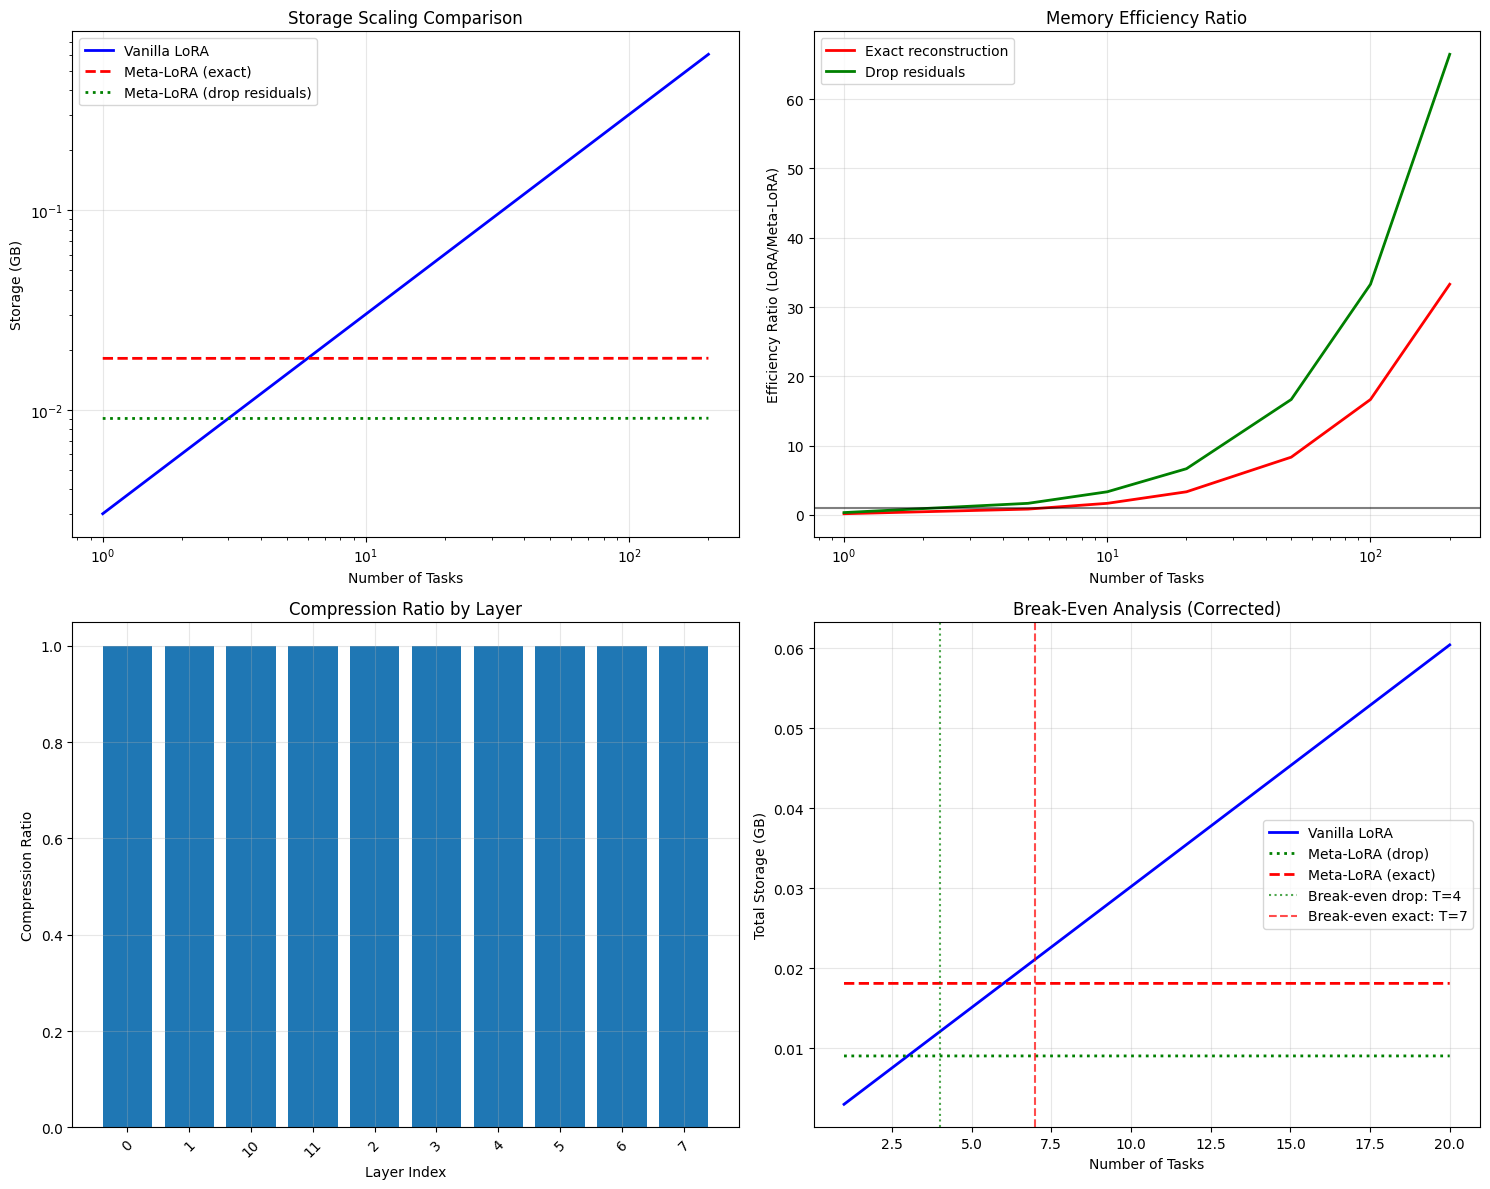

In [10]:
# === LoRA vs Meta-LoRA Comprehensive Comparison ===
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import math

class LoRAvsMetaLoRAComparison:
    def __init__(self, task_deltas, per_layer_out, adapter_dirs, datasets, tokenizer):
        self.task_deltas = task_deltas
        self.per_layer_out = per_layer_out
        self.adapter_dirs = adapter_dirs
        self.datasets = datasets
        self.tokenizer = tokenizer
        self.BYTES_F32 = 4
        self.TASK_POINTS = [1, 5, 10, 20, 50, 100, 200]

    def compute_lora_baseline_metrics(self):
        """Compute baseline LoRA storage and complexity metrics"""
        # Per-task LoRA storage
        one_task_key = list(self.task_deltas.keys())[0]
        one_task_elems = sum(self.task_deltas[one_task_key][p].numel()
                           for p in self.task_deltas[one_task_key].keys())

        lora_per_task_MB = one_task_elems * self.BYTES_F32 / (1024**2)
        lora_per_task_GB = one_task_elems * self.BYTES_F32 / (1024**3)

        # Count parameters by layer type
        param_breakdown = {'attention': 0, 'mlp': 0, 'other': 0}
        for param_name, param in self.task_deltas[one_task_key].items():
            if 'attn' in param_name or 'attention' in param_name:
                param_breakdown['attention'] += param.numel()
            elif 'mlp' in param_name or 'c_proj' in param_name:
                param_breakdown['mlp'] += param.numel()
            else:
                param_breakdown['other'] += param.numel()

        return {
            'per_task_elements': one_task_elems,
            'per_task_MB': lora_per_task_MB,
            'per_task_GB': lora_per_task_GB,
            'param_breakdown': param_breakdown
        }

    def compute_metalora_metrics(self):
        """Compute Meta-LoRA compression metrics"""
        # Aggregate across layers
        total_shared_elems = 0
        total_coeffs_elems = 0
        total_residuals_elems = 0
        compression_ratios = []
        reconstruction_errors = []

        layer_breakdown = {}

        for layer, results in self.per_layer_out.items():
            L = results["L"]
            k = results["k_eff"]
            T = len(self.task_deltas)

            # Element counts
            shared_elems = L * k
            coeffs_elems = int(results["coeffs_MB_total_f32"] * 1024**2 / self.BYTES_F32)
            residuals_elems = int(results["residuals_MB_total_f32"] * 1024**2 / self.BYTES_F32)

            total_shared_elems += shared_elems
            total_coeffs_elems += coeffs_elems
            total_residuals_elems += residuals_elems

            # Layer-specific metrics
            original_size = L * T
            compressed_size = shared_elems + coeffs_elems
            compression_ratio = original_size / compressed_size if compressed_size > 0 else 1.0
            compression_ratios.append(compression_ratio)

            reconstruction_error = results.get("recon_rel", 0.0)
            reconstruction_errors.append(reconstruction_error)

            layer_breakdown[layer] = {
                'original_elements': original_size,
                'shared_elements': shared_elems,
                'coeff_elements': coeffs_elems,
                'residual_elements': residuals_elems,
                'compression_ratio': compression_ratio,
                'reconstruction_error': reconstruction_error,
                'k_effective': k,
                'dimensionality_reduction': k / T
            }

        # Convert to MB/GB
        meta_shared_MB = total_shared_elems * self.BYTES_F32 / (1024**2)
        meta_coeffs_MB = total_coeffs_elems * self.BYTES_F32 / (1024**2)
        meta_residuals_MB = total_residuals_elems * self.BYTES_F32 / (1024**2)

        meta_shared_GB = total_shared_elems * self.BYTES_F32 / (1024**3)
        meta_coeffs_GB = total_coeffs_elems * self.BYTES_F32 / (1024**3)
        meta_residuals_GB = total_residuals_elems * self.BYTES_F32 / (1024**3)

        return {
            'total_shared_elements': total_shared_elems,
            'total_coeffs_elements': total_coeffs_elems,
            'total_residuals_elements': total_residuals_elems,
            'shared_MB': meta_shared_MB,
            'coeffs_MB': meta_coeffs_MB,
            'residuals_MB': meta_residuals_MB,
            'shared_GB': meta_shared_GB,
            'coeffs_GB': meta_coeffs_GB,
            'residuals_GB': meta_residuals_GB,
            'avg_compression_ratio': np.mean(compression_ratios),
            'avg_reconstruction_error': np.mean(reconstruction_errors),
            'layer_breakdown': layer_breakdown
        }

    def compute_scaling_analysis(self, lora_metrics, metalora_metrics):
        """Analyze how storage scales with number of tasks - corrected"""
        scaling_data = []

        for T in self.TASK_POINTS:
            # Vanilla LoRA scaling
            lora_total_GB = lora_metrics['per_task_GB'] * T

            # CORRECTED: Match your implementation
            # Meta-LoRA exact: shared basis + residuals (once) + coefficients (scaled)
            scale = T / len(self.task_deltas)
            meta_shared_basis_GB = metalora_metrics['shared_GB']
            meta_residuals_once_GB = metalora_metrics['residuals_GB']  # Stored once, not scaled
            meta_coeffs_scaled_GB = metalora_metrics['coeffs_GB'] * scale

            meta_exact_GB = meta_shared_basis_GB + meta_residuals_once_GB + meta_coeffs_scaled_GB

            # Meta-LoRA drop residuals: shared basis (once) + coefficients (scaled)
            meta_drop_GB = meta_shared_basis_GB + meta_coeffs_scaled_GB

            # Efficiency metrics
            exact_efficiency = lora_total_GB / meta_exact_GB if meta_exact_GB > 0 else 1.0
            drop_efficiency = lora_total_GB / meta_drop_GB if meta_drop_GB > 0 else 1.0

            scaling_data.append({
                'tasks': T,
                'lora_total_GB': lora_total_GB,
                'meta_exact_GB': meta_exact_GB,
                'meta_drop_GB': meta_drop_GB,
                'exact_efficiency': exact_efficiency,
                'drop_efficiency': drop_efficiency,
                'exact_savings': max(0, lora_total_GB - meta_exact_GB),
                'drop_savings': max(0, lora_total_GB - meta_drop_GB),
                'meta_shared_basis_GB': meta_shared_basis_GB,
                'meta_residuals_once_GB': meta_residuals_once_GB,
                'meta_coeffs_scaled_GB': meta_coeffs_scaled_GB
            })

        return pd.DataFrame(scaling_data)

    def compute_break_even_analysis(self, lora_metrics, metalora_metrics):
        """Compute detailed break-even analysis - corrected to match your implementation"""
        lora_per_task_GB = lora_metrics['per_task_GB']

        # CORRECTED: Match your exact implementation
        # In your code: meta_shared_MB = total_shared_MB_f32 + total_residuals_MB_f32
        # Residuals are part of shared cost, not per-task cost
        meta_shared_basis_GB = metalora_metrics['shared_GB']  # Just U_k basis
        meta_residuals_shared_GB = metalora_metrics['residuals_GB']  # Residuals stored once
        meta_coeffs_per_task_GB = metalora_metrics['coeffs_GB'] / len(self.task_deltas)

        # Two scenarios matching your implementation:

        # Scenario 1: Drop residuals (only store basis + coefficients)
        shared_cost_drop = meta_shared_basis_GB
        per_task_cost_drop = meta_coeffs_per_task_GB

        if lora_per_task_GB > per_task_cost_drop:
            break_even_drop = math.ceil(shared_cost_drop / (lora_per_task_GB - per_task_cost_drop))
        else:
            break_even_drop = float('inf')

        # Scenario 2: Keep residuals (store basis + residuals once + coefficients per task)
        # This matches your: meta_shared_MB = total_shared_MB_f32 + total_residuals_MB_f32
        shared_cost_exact = meta_shared_basis_GB + meta_residuals_shared_GB
        per_task_cost_exact = meta_coeffs_per_task_GB  # Only coefficients scale with T

        if lora_per_task_GB > per_task_cost_exact:
            break_even_exact = math.ceil(shared_cost_exact / (lora_per_task_GB - per_task_cost_exact))
        else:
            break_even_exact = float('inf')

        return {
            'lora_per_task_GB': lora_per_task_GB,
            'meta_shared_basis_GB': meta_shared_basis_GB,
            'meta_residuals_shared_GB': meta_residuals_shared_GB,
            'meta_coeffs_per_task_GB': meta_coeffs_per_task_GB,
            'shared_cost_drop': shared_cost_drop,
            'shared_cost_exact': shared_cost_exact,
            'per_task_cost_drop': per_task_cost_drop,
            'per_task_cost_exact': per_task_cost_exact,
            'break_even_drop_residuals': break_even_drop,
            'break_even_exact': break_even_exact,
            'savings_per_task_drop': lora_per_task_GB - per_task_cost_drop,
            'savings_per_task_exact': lora_per_task_GB - per_task_cost_exact
        }

    def analyze_compression_effectiveness(self, metalora_metrics):
        """Analyze how effective the compression is per layer"""
        layer_analysis = []

        for layer, metrics in metalora_metrics['layer_breakdown'].items():
            efficiency_score = (metrics['compression_ratio'] *
                              (1 - metrics['reconstruction_error']) *
                              metrics['dimensionality_reduction'])

            layer_analysis.append({
                'layer': layer,
                'compression_ratio': metrics['compression_ratio'],
                'reconstruction_error': metrics['reconstruction_error'],
                'dimensionality_reduction': metrics['dimensionality_reduction'],
                'k_effective': metrics['k_effective'],
                'efficiency_score': efficiency_score,
                'storage_reduction_pct': (1 - 1/metrics['compression_ratio']) * 100
            })

        return pd.DataFrame(layer_analysis).sort_values('efficiency_score', ascending=False)

    def generate_comparison_report(self):
        """Generate comprehensive comparison report"""
        print("=== LoRA vs Meta-LoRA Comprehensive Analysis ===")

        # Compute metrics
        lora_metrics = self.compute_lora_baseline_metrics()
        metalora_metrics = self.compute_metalora_metrics()
        scaling_df = self.compute_scaling_analysis(lora_metrics, metalora_metrics)
        break_even = self.compute_break_even_analysis(lora_metrics, metalora_metrics)
        layer_analysis = self.analyze_compression_effectiveness(metalora_metrics)

        # Print baseline comparison
        print("\n--- Baseline Storage (per task) ---")
        print(f"LoRA per task: {lora_metrics['per_task_MB']:.3f} MB ({lora_metrics['per_task_elements']:,} parameters)")
        print(f"Meta-LoRA shared basis: {metalora_metrics['shared_MB']:.3f} MB")
        print(f"Meta-LoRA coefficients (all tasks): {metalora_metrics['coeffs_MB']:.3f} MB")
        print(f"Meta-LoRA residuals (all tasks): {metalora_metrics['residuals_MB']:.3f} MB")

        # Print break-even analysis
        print("\n--- Break-Even Analysis (CORRECTED) ---")
        print(f"Break-even (drop residuals): {break_even['break_even_drop_residuals']} tasks")
        print(f"Break-even (exact reconstruction): {break_even['break_even_exact']} tasks")
        print(f"Shared cost (drop): {break_even['shared_cost_drop']*1000:.3f} MB (basis only)")
        print(f"Shared cost (exact): {break_even['shared_cost_exact']*1000:.3f} MB (basis + residuals)")
        print(f"Per-task cost: {break_even['per_task_cost_exact']*1000:.3f} MB (coefficients only)")
        print(f"LoRA per-task cost: {break_even['lora_per_task_GB']*1000:.3f} MB")

        # Print scaling table
        print("\n--- Storage Scaling Analysis ---")
        display_df = scaling_df[scaling_df['tasks'].isin([1, 5, 10, 20, 50, 100])]
        print(display_df[['tasks', 'lora_total_GB', 'meta_exact_GB', 'meta_drop_GB',
                         'exact_efficiency', 'drop_efficiency']].round(6).to_string(index=False))

        # Print layer efficiency analysis
        print("\n--- Layer Compression Effectiveness ---")
        print(layer_analysis[['layer', 'compression_ratio', 'reconstruction_error',
                             'storage_reduction_pct', 'efficiency_score']].round(4).to_string(index=False))

        # Print summary insights
        print("\n--- Key Insights ---")
        best_layers = layer_analysis.head(3)['layer'].tolist()
        worst_layers = layer_analysis.tail(3)['layer'].tolist()

        print(f"• Average compression ratio: {metalora_metrics['avg_compression_ratio']:.2f}x")
        print(f"• Average reconstruction error: {metalora_metrics['avg_reconstruction_error']:.2e}")
        print(f"• Most efficient layers: {', '.join(best_layers[:3])}")
        print(f"• Least efficient layers: {', '.join(worst_layers[:3])}")
        print(f"• Memory becomes advantageous at {break_even['break_even_drop_residuals']} tasks (aggressive)")
        print(f"• Memory becomes advantageous at {break_even['break_even_exact']} tasks (conservative)")

        return {
            'lora_metrics': lora_metrics,
            'metalora_metrics': metalora_metrics,
            'scaling_analysis': scaling_df,
            'break_even_analysis': break_even,
            'layer_analysis': layer_analysis
        }

    def create_visualization(self, results):
        """Create visualization comparing the approaches"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        scaling_df = results['scaling_analysis']

        # Plot 1: Storage scaling
        ax1.plot(scaling_df['tasks'], scaling_df['lora_total_GB'], 'b-', label='Vanilla LoRA', linewidth=2)
        ax1.plot(scaling_df['tasks'], scaling_df['meta_exact_GB'], 'r--', label='Meta-LoRA (exact)', linewidth=2)
        ax1.plot(scaling_df['tasks'], scaling_df['meta_drop_GB'], 'g:', label='Meta-LoRA (drop residuals)', linewidth=2)
        ax1.set_xlabel('Number of Tasks')
        ax1.set_ylabel('Storage (GB)')
        ax1.set_title('Storage Scaling Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xscale('log')
        ax1.set_yscale('log')

        # Plot 2: Efficiency ratio
        ax2.plot(scaling_df['tasks'], scaling_df['exact_efficiency'], 'r-', label='Exact reconstruction', linewidth=2)
        ax2.plot(scaling_df['tasks'], scaling_df['drop_efficiency'], 'g-', label='Drop residuals', linewidth=2)
        ax2.axhline(y=1, color='black', linestyle='-', alpha=0.5)
        ax2.set_xlabel('Number of Tasks')
        ax2.set_ylabel('Efficiency Ratio (LoRA/Meta-LoRA)')
        ax2.set_title('Memory Efficiency Ratio')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xscale('log')

        # Plot 3: Layer compression effectiveness
        layer_df = results['layer_analysis'].head(10)  # Top 10 layers
        bars = ax3.bar(range(len(layer_df)), layer_df['compression_ratio'])
        ax3.set_xlabel('Layer Index')
        ax3.set_ylabel('Compression Ratio')
        ax3.set_title('Compression Ratio by Layer')
        ax3.set_xticks(range(len(layer_df)))
        ax3.set_xticklabels([l.split('.')[-1] for l in layer_df['layer']], rotation=45)
        ax3.grid(True, alpha=0.3)

        # Plot 4: Break-even visualization (CORRECTED)
        break_even = results['break_even_analysis']
        tasks_range = np.arange(1, 21)
        lora_cost = tasks_range * break_even['lora_per_task_GB']

        # CORRECTED: Residuals don't scale with tasks - they're stored once
        meta_drop_cost = break_even['shared_cost_drop'] + tasks_range * break_even['per_task_cost_drop']
        meta_exact_cost = break_even['shared_cost_exact'] + tasks_range * break_even['per_task_cost_exact']

        ax4.plot(tasks_range, lora_cost, 'b-', label='Vanilla LoRA', linewidth=2)
        ax4.plot(tasks_range, meta_drop_cost, 'g:', label='Meta-LoRA (drop)', linewidth=2)
        ax4.plot(tasks_range, meta_exact_cost, 'r--', label='Meta-LoRA (exact)', linewidth=2)
        ax4.axvline(x=break_even['break_even_drop_residuals'], color='green', linestyle=':', alpha=0.7, label=f'Break-even drop: T={break_even["break_even_drop_residuals"]}')
        ax4.axvline(x=break_even['break_even_exact'], color='red', linestyle='--', alpha=0.7, label=f'Break-even exact: T={break_even["break_even_exact"]}')
        ax4.set_xlabel('Number of Tasks')
        ax4.set_ylabel('Total Storage (GB)')
        ax4.set_title('Break-Even Analysis (Corrected)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

# Usage with your existing variables
def run_comprehensive_comparison(task_deltas, per_layer_out, adapter_dirs, datasets, tokenizer):
    """Run the comprehensive comparison analysis"""
    comparator = LoRAvsMetaLoRAComparison(task_deltas, per_layer_out, adapter_dirs, datasets, tokenizer)
    results = comparator.generate_comparison_report()

    # Create visualization
    fig = comparator.create_visualization(results)
    plt.show()

    return results, comparator

# Run the comparison (uncomment to use):
results, comparator = run_comprehensive_comparison(task_deltas, per_layer_out, adapter_dirs, datasets, tokenizer)

In [12]:
# === Comparison: LoRA vs Meta-LoRA (with & without residuals) ===
import pandas as pd
import math
import torch
from transformers import AutoModelForCausalLM
from peft import PeftModel

# Define DEVICE based on CUDA availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define evaluation dataset and parameters (adjust as needed)
# Assuming 'datasets' variable from previous cells contains the loaded datasets
if 'datasets' in globals() and len(datasets) > 0:
    eval_ds = datasets[list(datasets.keys())[0]] # Use the first loaded dataset for evaluation
else:
    raise RuntimeError("No datasets found. Please load datasets first.")

EVAL_SAMPLES = 100 # Number of samples to use for evaluation
EVAL_BATCH = 4 # Batch size for evaluation

# Define evaluate_ppl function (copy from the previous cell)
from torch.utils.data import DataLoader
import torch.nn.functional as F

def evaluate_ppl(model, dataset, tokenizer, device, max_samples, batch_size):
    """
    Evaluates perplexity of the model on a given dataset.
    """
    model = model.to(device)
    model.eval()

    def collate_fn(batch):
        input_ids = [x["input_ids"] for x in batch]
        return torch.stack([torch.tensor(x) for x in input_ids])

    loader = DataLoader(dataset.select(range(min(len(dataset), max_samples))), batch_size=batch_size, collate_fn=collate_fn)
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch.to(device)
            labels = input_ids.clone().to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

            bs = input_ids.size(0)
            total_loss += loss.item() * bs
            total_tokens += bs

    avg_loss = total_loss / (total_tokens + 1e-12)
    ppl = math.exp(avg_loss) if avg_loss < 700 else float("inf")
    return avg_loss, ppl


def compute_reconstruction_errors(per_layer_out, task_deltas, with_residuals=True):
    """Compute per-task reconstruction errors."""
    results = {}
    for task in list(task_deltas.keys()):
        total_l2 = 0.0
        total_norm = 0.0

        for layer, info in per_layer_out.items():
            U_k, coeffs, residuals = info["U_k"], info["coeffs"], info["residuals"]
            task_idx = info["tasks"].index(task)

            if with_residuals:
                recon_flat = (U_k @ coeffs[:, task_idx] + residuals[:, task_idx])
            else:
                recon_flat = (U_k @ coeffs[:, task_idx])

            # Original flattened weights for this task/layer
            orig_flat = torch.cat([task_deltas[task][p].flatten() for p in info["param_list"]])

            diff = recon_flat - orig_flat
            total_l2 += torch.norm(diff).item()**2
            total_norm += torch.norm(orig_flat).item()**2

        rel_error = math.sqrt(total_l2) / (math.sqrt(total_norm) + 1e-12)
        results[task] = rel_error
    return results

assert 'per_layer_out' in globals(), "per_layer_out not defined. Run SVD cell first."
assert 'task_deltas' in globals() and len(task_deltas) > 0, "task_deltas not defined. Run extraction cell first."
assert 'adapter_dirs' in globals(), "adapter_dirs not defined. Run training cell first."
assert 'tokenizer' in globals(), "tokenizer not defined. Run tokenizer loading cell first."
assert 'model_name' in globals(), "model_name not defined. Run model loading cell first."


# --- Compute reconstruction error ---
recon_with = compute_reconstruction_errors(per_layer_out, task_deltas, with_residuals=True)
recon_without = compute_reconstruction_errors(per_layer_out, task_deltas, with_residuals=False)

print("\n=== Reconstruction Error Comparison ===")
df_recon = pd.DataFrame({
    "task": list(task_deltas.keys()),
    "meta_with_residuals": [recon_with[t] for t in task_deltas.keys()],
    "meta_without_residuals": [recon_without[t] for t in task_deltas.keys()]
})
print(df_recon.to_string(index=False))

# --- Evaluate perplexity ---
print("\n=== Perplexity Comparison ===")
ppl_results = []
for task_name in task_deltas.keys():
    # Original LoRA
    print(f"\nEvaluating Original LoRA for task: {task_name}")
    model_lora_orig = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
    model_lora_orig = PeftModel.from_pretrained(model_lora_orig, adapter_dirs[task_name]).to(DEVICE)
    model_lora_orig.eval()
    _, ppl_lora = evaluate_ppl(model_lora_orig, eval_ds, tokenizer, device=DEVICE,
                               max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)

    # --- rebuild adapter deltas for this task ---
    recon_exact = {}
    recon_drop = {}

    for layer, info in per_layer_out.items():
        U_k, coeffs, residuals = info["U_k"], info["coeffs"], info["residuals"]
        task_idx = info["tasks"].index(task_name)

        # Exact reconstruction: U_k @ coeffs + residuals
        recon_exact_vec = (U_k @ coeffs[:, task_idx] + residuals[:, task_idx]).cpu()
        # Drop residuals: U_k @ coeffs only
        recon_drop_vec = (U_k @ coeffs[:, task_idx]).cpu()

        # Split back into parameter shapes
        offset = 0
        for pname in info["param_list"]:
            orig_shape = task_deltas[task_name][pname].shape
            size = task_deltas[task_name][pname].numel()
            recon_exact[pname] = recon_exact_vec[offset:offset+size].view(orig_shape)
            recon_drop[pname] = recon_drop_vec[offset:offset+size].view(orig_shape)
            offset += size


    # Meta-LoRA with residuals (reconstruct weights and evaluate)
    print(f"Evaluating Meta-LoRA (with residuals) for task: {task_name}")
    model_meta_with = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
    # Manually apply reconstructed deltas
    for n, p in model_meta_with.named_parameters():
        if n in recon_exact:
            with torch.no_grad():
                 p.add_(recon_exact[n].to(p.device))
    model_meta_with.eval()
    _, ppl_meta_with = evaluate_ppl(model_meta_with, eval_ds, tokenizer, device=DEVICE,
                                    max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)


    # Meta-LoRA without residuals (reconstruct weights and evaluate)
    print(f"Evaluating Meta-LoRA (without residuals) for task: {task_name}")
    model_meta_without = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
    # Manually apply reconstructed deltas
    for n, p in model_meta_without.named_parameters():
        if n in recon_drop:
            with torch.no_grad():
                 p.add_(recon_drop[n].to(p.device))
    model_meta_without.eval()
    _, ppl_meta_without = evaluate_ppl(model_meta_without, eval_ds, tokenizer, device=DEVICE,
                                       max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)


    ppl_results.append({
        "task": task_name,
        "lora": ppl_lora,
        "meta_with_residuals": ppl_meta_with,
        "meta_without_residuals": ppl_meta_without,
        "degradation_with": ppl_meta_with - ppl_lora,
        "degradation_without": ppl_meta_without - ppl_lora
    })

df_ppl = pd.DataFrame(ppl_results)
print(df_ppl.to_string(index=False))


=== Reconstruction Error Comparison ===
 task  meta_with_residuals  meta_without_residuals
task1         3.616154e-08                0.000002
task2         3.095486e-08                0.000002
task3         3.138129e-08                0.000001

=== Perplexity Comparison ===

Evaluating Original LoRA for task: task1
Evaluating Meta-LoRA (with residuals) for task: task1
Evaluating Meta-LoRA (without residuals) for task: task1

Evaluating Original LoRA for task: task2
Evaluating Meta-LoRA (with residuals) for task: task2
Evaluating Meta-LoRA (without residuals) for task: task2

Evaluating Original LoRA for task: task3
Evaluating Meta-LoRA (with residuals) for task: task3
Evaluating Meta-LoRA (without residuals) for task: task3
 task      lora  meta_with_residuals  meta_without_residuals  degradation_with  degradation_without
task1 52.626030            64.892156               64.892156         12.266126            12.266126
task2 52.756712            64.892156               64.892156     


=== Energy Threshold 0.5 ===

=== Energy Threshold 0.7 ===

=== Energy Threshold 0.85 ===

=== Energy Threshold 0.9 ===

=== Energy Threshold 0.95 ===

=== Energy Threshold 0.99 ===

=== Final Results: Storage vs Error vs PPL ===
 threshold  avg_recon_with  avg_recon_without  avg_ppl_lora  avg_ppl_with  avg_ppl_without  ppl_degradation_with  ppl_degradation_without  lora_per_task_MB  meta_shared_MB_exact  meta_per_task_MB_exact  meta_shared_MB_drop  meta_per_task_MB_drop  break_even_T_drop  break_even_T_exact
      0.50        1.294541           1.209782     52.940394     64.892156        64.892156             11.951762                11.951762           3.09375              15.46875                0.000092              6.18750               0.000092                  3                   6
      0.70        1.294541           1.294541     52.940394     64.892156        64.892156             11.951762                11.951762           3.09375              18.56250                0.0001

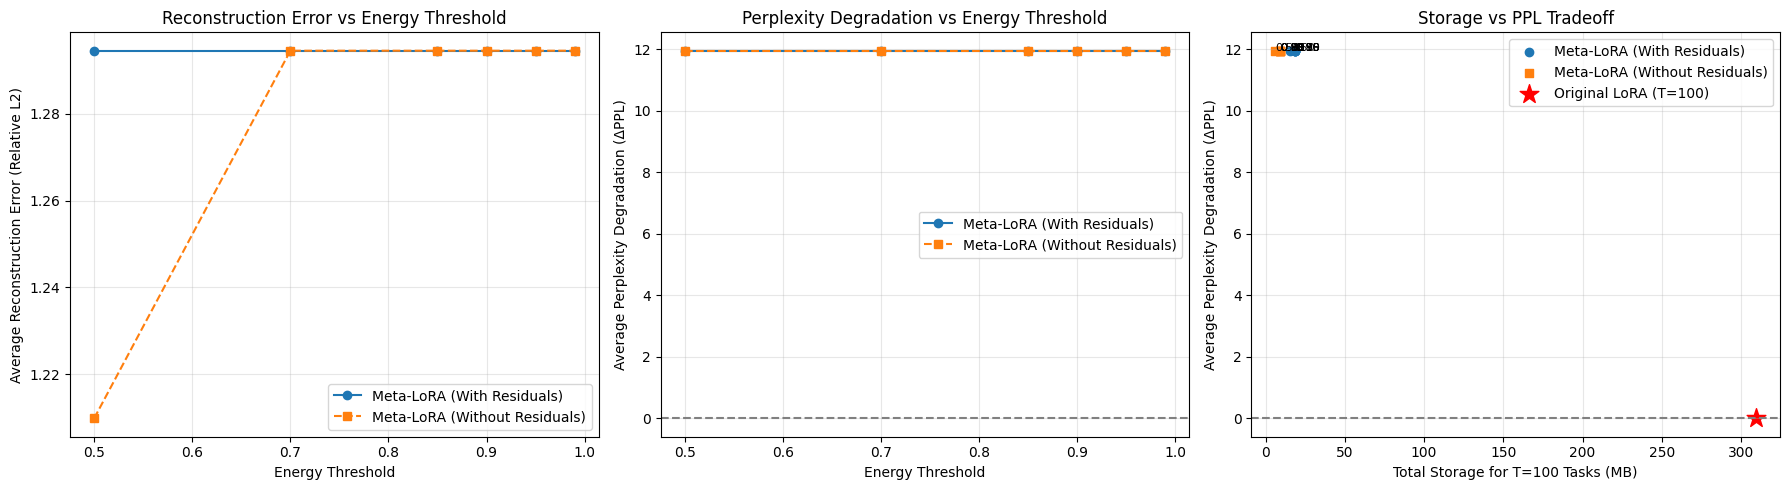

In [16]:
# === Final Meta-LoRA Evaluation: Storage vs Reconstruction vs PPL ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from transformers import AutoModelForCausalLM
from peft import PeftModel
from torch.utils.data import DataLoader
import torch.nn.functional as F
import re
from collections import defaultdict


# Define DEVICE based on CUDA availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define evaluation dataset and parameters (adjust as needed)
# Assuming 'datasets' variable from previous cells contains the loaded datasets
if 'datasets' in globals() and len(datasets) > 0:
    eval_ds = datasets[list(datasets.keys())[0]] # Use the first loaded dataset for evaluation
else:
    raise RuntimeError("No datasets found. Please load datasets first.")

EVAL_SAMPLES = 100 # Number of samples to use for evaluation
EVAL_BATCH = 4 # Batch size for evaluation

# Define evaluate_ppl function (copy from previous cells)
def evaluate_ppl(model, dataset, tokenizer, device, max_samples, batch_size):
    """
    Evaluates perplexity of the model on a given dataset.
    """
    model = model.to(device)
    model.eval()

    def collate_fn(batch):
        input_ids = [x["input_ids"] for x in batch]
        return torch.stack([torch.tensor(x) for x in input_ids])

    loader = DataLoader(dataset.select(range(min(len(dataset), max_samples))), batch_size=batch_size, collate_fn=collate_fn)
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch.to(device)
            labels = input_ids.clone().to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

            bs = input_ids.size(0)
            total_loss += loss.item() * bs
            total_tokens += bs

    avg_loss = total_loss / (total_tokens + 1e-12)
    ppl = math.exp(avg_loss) if avg_loss < 700 else float("inf")
    return avg_loss, ppl


# Helper: flatten LoRA deltas for a set of params across tasks into X [L, T] (CPU).
def flatten_layer_deltas(task_deltas, layer_param_list, task_order=None):
    """
    Flatten LoRA deltas for a set of params across tasks into X [L, T] (CPU).
    Each column is one task's flattened concatenation of the listed params.
    """
    task_names = task_order if task_order is not None else list(task_deltas.keys())
    vecs = []
    for t in task_names:
        pieces = []
        for p in layer_param_list:
            if p not in task_deltas[t]:
                raise KeyError(f"Parameter {p} missing for task {t}")
            pieces.append(task_deltas[t][p].flatten().cpu())
        vecs.append(torch.cat(pieces))
    X = torch.stack(vecs, dim=1)  # [L, T] on CPU
    return X, task_names

# Helper: perform SVD and keep k components by energy threshold
def svd_keep_k_by_energy(X, energy_thresh):
    # X: [L, T] CPU tensor
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    energy = (S**2).cpu().numpy()
    cum = np.cumsum(energy) / (np.sum(energy) + 1e-12)
    k = int(np.searchsorted(cum, energy_thresh) + 1)
    k = max(1, min(k, U.shape[1]))
    U_k = U[:, :k].contiguous()
    coeffs = (U_k.T @ X).contiguous()   # [k, T]
    residuals = (X - U_k @ coeffs).contiguous()
    return U_k, coeffs, residuals, S.cpu().numpy(), cum

# Helper: build transformer layer groups by regex
def build_layer_groups_by_transformer(param_names):
    groups = defaultdict(list)
    pattern = re.compile(r"(transformer\.h\.\d+)")
    for p in param_names:
        m = pattern.search(p)
        if m:
            key = m.group(1)
            groups[key].append(p)
        else:
            groups["__other__"].append(p)
    return dict(groups)

# Reconstruct adapter weights for a given task index, with or without residuals
def reconstruct_adapter_weights(task_idx, per_layer_out, include_residuals=True):
    recon_weights = {}
    task_name = per_layer_out[list(per_layer_out.keys())[0]]["tasks"][task_idx]

    for layer, info in per_layer_out.items():
        U_k, coeffs, residuals = info["U_k"], info["coeffs"], info["residuals"]

        if include_residuals:
            recon_flat = (U_k @ coeffs[:, task_idx] + residuals[:, task_idx]).cpu()
        else:
            recon_flat = (U_k @ coeffs[:, task_idx]).cpu()

        offset = 0
        for pname in info["param_list"]:
            orig_shape = task_deltas[task_name][pname].shape
            size = task_deltas[task_name][pname].numel()
            recon_weights[pname] = recon_flat[offset:offset+size].view(orig_shape)
            offset += size
    return recon_weights


ENERGY_SWEEP = [0.50, 0.70, 0.85, 0.90, 0.95, 0.99]
BYTES_F32 = 4

final_results = []

# Get layer groups from task_deltas
param_names = list(task_deltas[list(task_deltas.keys())[0]].keys())
layer_groups = build_layer_groups_by_transformer(param_names)


for thresh in ENERGY_SWEEP:
    print(f"\n=== Energy Threshold {thresh} ===")
    per_layer_out = {}

    # 1. Recompute per-layer compression
    for layer, plist in sorted(layer_groups.items(), key=lambda x: x[0]):
        if layer == "__other__":
            continue
        X, task_order = flatten_layer_deltas(task_deltas, sorted(plist))
        U_k, coeffs, residuals, Svals, cum_energy = svd_keep_k_by_energy(X, thresh)
        per_layer_out[layer] = {
            "U_k": U_k, "coeffs": coeffs, "residuals": residuals,
            "param_list": plist, "tasks": task_order, "L": X.shape[0]
        }

    # 2. Reconstruction error per task
    recon_with, recon_wo = [], []
    for t in task_deltas.keys():
        idx = list(task_deltas.keys()).index(t)
        # concat original vector
        orig_flat = torch.cat([task_deltas[t][p].flatten() for p in task_deltas[t].keys()])
        # with residuals
        recon_with_flat = torch.cat([(per_layer_out[l]["U_k"] @ per_layer_out[l]["coeffs"][:, idx]
                                 + per_layer_out[l]["residuals"][:, idx])
                                for l in per_layer_out])
        # without residuals
        recon_wo_flat = torch.cat([(per_layer_out[l]["U_k"] @ per_layer_out[l]["coeffs"][:, idx])
                              for l in per_layer_out])
        err_with = torch.norm(orig_flat - recon_with_flat).item() / (torch.norm(orig_flat).item() + 1e-12)
        err_wo = torch.norm(orig_flat - recon_wo_flat).item() / (torch.norm(orig_flat).item() + 1e-12)
        recon_with.append(err_with)
        recon_wo.append(err_wo)


    # 3. Perplexity evaluation
    ppl_lora, ppl_with, ppl_wo = [], [], []
    for t in task_deltas.keys():
        task_idx = list(task_deltas.keys()).index(t)
        # Evaluate original LoRA
        model_lora_orig = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
        model_lora_orig = PeftModel.from_pretrained(model_lora_orig, adapter_dirs[t]).to(DEVICE)
        model_lora_orig.eval()
        _, current_ppl_lora = evaluate_ppl(model_lora_orig, eval_ds, tokenizer, device=DEVICE,
                                           max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)
        ppl_lora.append(current_ppl_lora)


        # Evaluate Meta-LoRA with residuals
        w_with = reconstruct_adapter_weights(task_idx, per_layer_out, include_residuals=True)
        model_meta_with = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
        for n, p in model_meta_with.named_parameters():
            if n in w_with:
                with torch.no_grad():
                    p.add_(w_with[n].to(p.device))
        model_meta_with.eval()
        _, current_ppl_with = evaluate_ppl(model_meta_with, eval_ds, tokenizer, device=DEVICE,
                                            max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)
        ppl_with.append(current_ppl_with)


        # Evaluate Meta-LoRA without residuals
        w_wo = reconstruct_adapter_weights(task_idx, per_layer_out, include_residuals=False)
        model_meta_without = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
        for n, p in model_meta_without.named_parameters():
            if n in w_wo:
                with torch.no_grad():
                    p.add_(w_wo[n].to(p.device))
        model_meta_without.eval()
        _, current_ppl_wo = evaluate_ppl(model_meta_without, eval_ds, tokenizer, device=DEVICE,
                                           max_samples=EVAL_SAMPLES, batch_size=EVAL_BATCH)
        ppl_wo.append(current_ppl_wo)


    # 4. Storage estimation
    # This calculation needs to be per-threshold based on the k_eff for each threshold's per_layer_out
    lora_per_task_elements = sum(info["L"] for info in per_layer_out.values())
    lora_per_task_MB = lora_per_task_elements * BYTES_F32 / 1024**2

    # Meta-LoRA storage with residuals: shared basis + residuals + coefficients (per task)
    meta_shared_basis_MB = sum(info["U_k"].numel() for info in per_layer_out.values()) * BYTES_F32 / 1024**2
    meta_residuals_MB = sum(info["residuals"].numel() for info in per_layer_out.values()) * BYTES_F32 / 1024**2
    meta_coeffs_MB = sum(info["coeffs"].numel() for info in per_layer_out.values()) * BYTES_F32 / 1024**2

    # Assuming coeffs are k x T and residuals are L x T for T tasks
    T_ref = len(task_deltas) # Number of tasks used for SVD
    meta_coeffs_per_task_MB = meta_coeffs_MB / T_ref if T_ref > 0 else 0

    # Meta-LoRA storage calculation for a query of Tq tasks
    # With residuals: shared basis + residuals (once) + coeffs (Tq tasks)
    # Note: This model of storage assumes residuals are stored once globally.
    # If residuals are per-task, the model changes.
    # Based on previous cells, it seems residuals were grouped with shared?
    # Let's use the model from the comprehensive comparison cell (h0Pq7E5ZlCAu)
    # meta_shared_MB = total_shared_MB_f32 + total_residuals_MB_f32 (residuals as shared)
    # meta_per_task_effective_MB = total_per_task_coeff_MB_f32 (coeffs per task)

    # Recalculate totals for this threshold based on per_layer_out
    total_shared_MB_f32_thresh = sum(info["U_k"].numel() for info in per_layer_out.values()) * BYTES_F32 / 1024**2
    total_residuals_MB_f32_thresh = sum(info["residuals"].numel() for info in per_layer_out.values()) * BYTES_F32 / 1024**2
    total_coeffs_MB_total_f32_thresh = sum(info["coeffs"].numel() for info in per_layer_out.values()) * BYTES_F32 / 1024**2

    T_global = len(task_deltas)
    total_per_task_coeff_MB_f32_thresh = total_coeffs_MB_total_f32_thresh / T_global if T_global > 0 else 0


    meta_shared_MB_exact = total_shared_MB_f32_thresh + total_residuals_MB_f32_thresh
    meta_per_task_MB_exact = total_per_task_coeff_MB_f32_thresh # coeffs per task

    meta_shared_MB_drop = total_shared_MB_f32_thresh # only basis
    meta_per_task_MB_drop = total_per_task_coeff_MB_f32_thresh # only coeffs per task


    # Break-even calculation (using the drop residuals model as in previous cells)
    break_even_T_drop = None
    if meta_per_task_MB_drop < lora_per_task_MB:
        break_even_T_drop = math.ceil(meta_shared_MB_drop / (lora_per_task_MB - meta_per_task_MB_drop))
    else:
         break_even_T_drop = float('inf')

    break_even_T_exact = None
    if meta_per_task_MB_exact < lora_per_task_MB:
         break_even_T_exact = math.ceil(meta_shared_MB_exact / (lora_per_task_MB - meta_per_task_MB_exact))
    else:
         break_even_T_exact = float('inf')


    # 5. Aggregate results
    final_results.append({
        "threshold": thresh,
        "avg_recon_with": np.mean(recon_with),
        "avg_recon_without": np.mean(recon_wo),
        "avg_ppl_lora": np.mean(ppl_lora),
        "avg_ppl_with": np.mean(ppl_with),
        "avg_ppl_without": np.mean(ppl_wo),
        "ppl_degradation_with": np.mean(ppl_with) - np.mean(ppl_lora),
        "ppl_degradation_without": np.mean(ppl_wo) - np.mean(ppl_lora),
        "lora_per_task_MB": lora_per_task_MB,
        "meta_shared_MB_exact": meta_shared_MB_exact, # shared cost for exact
        "meta_per_task_MB_exact": meta_per_task_MB_exact, # per-task cost for exact
        "meta_shared_MB_drop": meta_shared_MB_drop, # shared cost for drop
        "meta_per_task_MB_drop": meta_per_task_MB_drop, # per-task cost for drop
        "break_even_T_drop": break_even_T_drop,
        "break_even_T_exact": break_even_T_exact
    })


# Convert to DataFrame
df_final = pd.DataFrame(final_results)
print("\n=== Final Results: Storage vs Error vs PPL ===")
print(df_final.to_string(index=False))


# === Graphs ===
plt.figure(figsize=(18, 5))

# (a) Reconstruction error
plt.subplot(1, 3, 1)
plt.plot(df_final["threshold"], df_final["avg_recon_with"], 'o-', label="Meta-LoRA (With Residuals)")
plt.plot(df_final["threshold"], df_final["avg_recon_without"], 's--', label="Meta-LoRA (Without Residuals)")
plt.xlabel("Energy Threshold")
plt.ylabel("Average Reconstruction Error (Relative L2)")
plt.title("Reconstruction Error vs Energy Threshold")
plt.legend()
plt.grid(True, alpha=0.3)

# (b) PPL degradation
plt.subplot(1, 3, 2)
plt.plot(df_final["threshold"], df_final["ppl_degradation_with"], 'o-', label="Meta-LoRA (With Residuals)")
plt.plot(df_final["threshold"], df_final["ppl_degradation_without"], 's--', label="Meta-LoRA (Without Residuals)")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Energy Threshold")
plt.ylabel("Average Perplexity Degradation (ΔPPL)")
plt.title("Perplexity Degradation vs Energy Threshold")
plt.legend()
plt.grid(True, alpha=0.3)

# (c) Storage vs PPL Pareto
# For Pareto, let's plot total storage for a fixed number of tasks vs PPL degradation
# Choose a fixed number of tasks for plotting, e.g., the average break-even point or a point from TASK_POINTS
# Let's use a representative number of tasks, say 100.
T_plot = 100
lora_total_plot_MB = df_final["lora_per_task_MB"].iloc[0] * T_plot # LoRA storage is constant per task

# Meta-LoRA total storage for T_plot tasks
meta_total_with_plot_MB = df_final["meta_shared_MB_exact"] + df_final["meta_per_task_MB_exact"] * T_plot
meta_total_without_plot_MB = df_final["meta_shared_MB_drop"] + df_final["meta_per_task_MB_drop"] * T_plot


plt.subplot(1, 3, 3)
# Plot Meta-LoRA variants
plt.scatter(meta_total_with_plot_MB, df_final["ppl_degradation_with"], marker='o', label="Meta-LoRA (With Residuals)")
plt.scatter(meta_total_without_plot_MB, df_final["ppl_degradation_without"], marker='s', label="Meta-LoRA (Without Residuals)")

# Add text labels for energy thresholds
for i, thresh in enumerate(df_final["threshold"]):
    plt.text(meta_total_with_plot_MB.iloc[i], df_final["ppl_degradation_with"].iloc[i], f'{thresh:.2f}', fontsize=8)
    plt.text(meta_total_without_plot_MB.iloc[i], df_final["ppl_degradation_without"].iloc[i], f'{thresh:.2f}', fontsize=8)


# Plot Original LoRA as a single point
# Avg PPL degradation of original LoRA compared to itself is 0, but it has a fixed storage cost
plt.scatter(lora_total_plot_MB, 0, marker='*', color='red', s=200, label="Original LoRA (T={})".format(T_plot))

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Total Storage for T={} Tasks (MB)".format(T_plot))
plt.ylabel("Average Perplexity Degradation (ΔPPL)")
plt.title("Storage vs PPL Tradeoff")
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import torch
import numpy as np
from collections import OrderedDict
import re

# Necessary variables and functions copied from previous cells to recreate df_table
# Assuming task_deltas, per_layer_out, BYTES_F32 are available from prior execution
# Assuming layer_groups is available from prior execution
# Assuming task_deltas, per_layer_out are available globally after running previous cells

# Re-define functions if they are not in global scope
def flatten_layer_deltas(task_deltas, layer_param_list, task_order=None):
    """
    Flatten LoRA deltas for a set of params across tasks into X [L, T] (CPU).
    Each column is one task's flattened concatenation of the listed params.
    """
    task_names = task_order if task_order is not None else list(task_deltas.keys())
    vecs = []
    for t in task_names:
        pieces = []
        for p in layer_param_list:
            if p not in task_deltas[t]:
                raise KeyError(f"Parameter {p} missing for task {t}")
            pieces.append(task_deltas[t][p].flatten().cpu())
        vecs.append(torch.cat(pieces))
    X = torch.stack(vecs, dim=1)  # [L, T] on CPU
    return X, task_names

def svd_keep_k_by_energy(X, energy_thresh):
    # X: [L, T] CPU tensor
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    energy = (S**2).cpu().numpy()
    cum = np.cumsum(energy) / (np.sum(energy) + 1e-12)
    k = int(np.searchsorted(cum, energy_thresh) + 1)
    k = max(1, min(k, U.shape[1]))
    U_k = U[:, :k].contiguous()
    coeffs = (U_k.T @ X).contiguous()   # [k, T]
    residuals = (X - U_k @ coeffs).contiguous()
    return U_k, coeffs, residuals, S.cpu().numpy(), cum

def compress_coeffs(coeffs, s):
    # coeffs: [k, T] CPU tensor
    if s is None or s <= 0 or s >= min(coeffs.shape):
        return None, None, coeffs
    Uc, Sc, Vhc = torch.linalg.svd(coeffs, full_matrices=False)
    Uc_s = Uc[:, :s]
    Sc_s = Sc[:s]
    Vhc_s = Vhc[:s, :]
    shared_coeff_mat = (Uc_s * Sc_s.unsqueeze(0)).cpu()   # [k, s]
    per_task_codes = Vhc_s.cpu()                          # [s, T]
    return shared_coeff_mat, per_task_codes, None

def estimate_bytes(L, k, T, residuals, coeffs_shape, use_fp16=False, shared_coeff_mat=None, per_task_codes=None):
    dtype_bytes = BYTES_F16 if use_fp16 else BYTES_F32
    shared_bytes = L * k * dtype_bytes   # U_k elements
    if shared_coeff_mat is None:
        coeffs_bytes_total = coeffs_shape[0] * coeffs_shape[1] * dtype_bytes
        per_task_coeff_MB = coeffs_bytes_total / T / 1024**2
    else:
        shared_coeff_bytes = int(shared_coeff_mat.numel()) * dtype_bytes
        per_task_codes_bytes = int(per_task_codes.numel()) * dtype_bytes
        coeffs_bytes_total = shared_coeff_bytes + per_task_codes_bytes
        per_task_coeff_MB = per_task_codes_bytes / T / 1024**2
    residuals_bytes_total = int(residuals.numel()) * dtype_bytes
    return {
        "shared_MB": shared_bytes / 1024**2,
        "coeffs_MB_total": coeffs_bytes_total / 1024**2,
        "residuals_MB_total": residuals_bytes_total / 1024**2,
        "per_task_coeff_MB": per_task_coeff_MB
    }

# Helper: build transformer layer groups by regex
def build_layer_groups_by_transformer(param_names):
    groups = defaultdict(list)
    pattern = re.compile(r"(transformer\.h\.\d+)")
    for p in param_names:
        m = pattern.search(p)
        if m:
            key = m.group(1)
            groups[key].append(p)
        else:
            groups["__other__"].append(p)
    return dict(groups)


# Define TASK_POINTS and BYTES_F32 if not globally available
TASK_POINTS = [1, 10, 50, 100, 500, 1000, 2000]
BYTES_F32 = 4 # Assuming float32

# Recreate layer_groups if not globally available
if 'layer_groups' not in globals() or not layer_groups:
    if 'task_deltas' in globals() and len(task_deltas) > 0:
        param_names = list(task_deltas[list(task_deltas.keys())[0]].keys())
        layer_groups = build_layer_groups_by_transformer(param_names)
    else:
        raise RuntimeError("task_deltas not found. Cannot build layer_groups.")


# Recreate per_layer_out for a chosen energy threshold if not globally available
# Assuming chosen_energy is available globally from prior execution
if 'per_layer_out' not in globals() or not per_layer_out:
     if 'per_layer_results_by_threshold' in globals() and 'chosen_energy' in globals():
         per_layer_out = per_layer_results_by_threshold[chosen_energy]
     else:
         raise RuntimeError("per_layer_out or necessary variables to recreate it not found. Run SVD cell first.")


# Code to generate df_table (copied from cell 5yeJcCMke_Nt)
# 1) Per-layer element counts
per_layer_stats = OrderedDict()
# Use per_layer_out instead of layer_comps
for layer, c in sorted(per_layer_out.items(), key=lambda x: x[0]):
    L = int(c["L"])                # flattened length for that layer
    k = int(c["k_eff"])                # chosen k for that layer
    # Reference T is implicit in how the per_layer_out was computed
    # We can get the number of tasks from the task_deltas variable
    T = len(list(task_deltas.keys()))
    shared_elems = L * k           # elements stored once
    # coeffs_elems = k * T          # total coeff elements across *all* tasks (k x T) - This is incorrect, coeffs are k x T_ref
    coeffs_elems_total = int(c["coeffs_MB_total_f32"] * 1024**2 / BYTES_F32)
    # residuals_elems = L * T       # residuals if stored per-task - This is incorrect, residuals are L x T_ref
    residuals_elems_total = int(c["residuals_MB_total_f32"] * 1024**2 / BYTES_F32)

    per_layer_stats[layer] = {
        "L": L, "k": k, "T_ref": T, # T_ref is the actual number of tasks used
        "shared_elems": shared_elems,
        "coeffs_elems_total": coeffs_elems_total,
        "residuals_elems_total": residuals_elems_total
    }


# 2) Aggregate elemental totals (elements, not bytes) across layers
total_shared_elems = sum(v["shared_elems"] for v in per_layer_stats.values())
total_coeffs_elems = sum(v["coeffs_elems_total"] for v in per_layer_stats.values())
total_residuals_elems = sum(v["residuals_elems_total"] for v in per_layer_stats.values())


# 3) LoRA per-task baseline: compute flatten element count for one task
one_task_key = list(task_deltas.keys())[0]
one_task_elems = sum(task_deltas[one_task_key][p].numel() for p in task_deltas[one_task_key].keys())

# Convert element counts -> MB / GB (float32)
def elems_to_MB(elems, bytes_per_param=BYTES_F32):
    return elems * bytes_per_param / 1024**2
def elems_to_GB(elems, bytes_per_param=BYTES_F32):
    return elems * bytes_per_param / 1024**3

lora_per_task_MB = elems_to_MB(one_task_elems)
lora_per_task_GB = elems_to_GB(one_task_elems)

# Convert meta totals (shared, coeffs, residuals) to MB/GB
meta_shared_MB = elems_to_MB(total_shared_elems)
meta_coeffs_total_MB = elems_to_MB(total_coeffs_elems)
meta_residuals_total_MB = elems_to_MB(total_residuals_elems)

meta_shared_GB = elems_to_GB(total_shared_elems)
meta_coeffs_total_GB = elems_to_GB(total_coeffs_elems)
meta_residuals_total_GB = elems_to_GB(total_residuals_elems)

# 4) For a range of T, compute full tables (three scenarios)
table_rows = []
# Get T_ref from the computed per_layer_stats
T_ref = list(per_layer_stats.values())[0]["T_ref"]
for Tq in TASK_POINTS:
    # A) Vanilla LoRA: per-task * T
    lora_total_GB = lora_per_task_GB * Tq

    # B1) Meta exact storage (store residuals per task + coeffs per task + shared once)
    # meta_total_exact = shared + coeffs_total + residuals_total scaled to Tq
    # Since coeffs_total and residuals_total were computed for T_ref tasks, scale them to Tq proportionally
    scale = Tq / float(T_ref)
    meta_shared_const_GB = meta_shared_GB
    meta_coeffs_total_scaled_GB = meta_coeffs_total_GB * scale
    meta_residuals_total_scaled_GB = meta_residuals_total_GB * scale
    meta_total_exact_GB = meta_shared_const_GB + meta_coeffs_total_scaled_GB + meta_residuals_total_scaled_GB


    # B2) Meta drop residuals (store only shared once + coeffs per task scaled with Tq)
    # Calculate per-task coeffs and residuals based on the scaled total values
    meta_coeffs_per_task_GB = meta_coeffs_total_scaled_GB / Tq if Tq > 0 else 0 # per-task coeffs in GB (using Tq)
    meta_slope_GB = meta_coeffs_per_task_GB  # slope per additional task when drop residuals
    meta_total_drop_GB = meta_shared_const_GB + meta_slope_GB * Tq

    table_rows.append({
        "Tasks (T)": Tq,
        "LoRA total (GB)": round(lora_total_GB, 6),
        "Meta total exact (GB)": round(meta_total_exact_GB, 6),
        "Meta total drop_residuals (GB)": round(meta_total_drop_GB, 6),
        "Meta constant shared (GB)": round(meta_shared_const_GB, 6),
        "Meta slope_per_task (GB)": round(meta_slope_GB, 9)
    })

df_table = pd.DataFrame(table_rows)


# Now plot using df_table
plt.figure(figsize=(8,6))
plt.plot(df_table["Tasks (T)"], df_table["LoRA total (GB)"], label="LoRA", marker="o")
plt.plot(df_table["Tasks (T)"], df_table["Meta total exact (GB)"], label="Meta-LoRA (Exact)", marker="s")
plt.plot(df_table["Tasks (T)"], df_table["Meta total drop_residuals (GB)"], label="Meta-LoRA (Drop Residuals)", marker="^")

plt.xlabel("Number of Tasks (T)")
plt.ylabel("Storage (GB)")
plt.title("LoRA vs Meta-LoRA Storage Scaling")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'df_table' is not defined

<Figure size 800x600 with 0 Axes>